# ISIDORA-PYX

In [160]:
from __future__ import print_function
from IPython.display import Image
%matplotlib inline

In [161]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%load_ext line_profiler

In [4]:
ic = %env ICDIR

In [5]:
import line_profiler

In [6]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

In [7]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [8]:
import pandas as pd
import tables as tb
import numpy as np
import tables

In [9]:
from system_of_units import *

In [10]:
from Util import *

In [11]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 

In [12]:
from Configure import *

In [13]:
import mplFunctions as mpl
import wfmFunctions as wfm

In [14]:
import tblFunctions as tbl

In [15]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [16]:
from scipy import signal as SGN 

In [17]:
import time

In [18]:
%load_ext Cython

In [19]:
import cProfile

### ISIDORA-PYX revisited on:

In [20]:
print(time.strftime("%d/%m/%Y"))

20/10/2016


In [21]:
print(time.strftime("%H:%M:%S"))

17:31:04


In [ ]:
Timer unit: 1e-06 s

Total time: 9.83155 s
File: <ipython-input-25-b37245159f5d>
Function: DBLR at line 222

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   222                                           def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
   223                                                    thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC, log='INFO'):
   224                                               """
   225                                               Peform Base line Restoration
   226                                               coeff_acc is an array with the coefficients of the accumulator
   227                                               Threshold 1 is used to decide when raw signal raises up above trigger line
   228                                               Threshold 2 is used to decide when reconstructed signal is above trigger line
   229                                               Threshold 3 is used to compare Raw and Rec signal
   230                                               """
   231         1            2      2.0      0.0      perform_blr = lambda wf,coef: BLR(FP.ceiling - wf, coef, mau_len, thr1, thr2, thr3, log)
   232         1      9831551 9831551.0    100.0      return map( perform_blr, pmtrd[event_number], coeff_acc )

In [213]:
%%cython

import numpy as np
cimport numpy as np
import pandas as pd
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 
from Util import wait



cpdef BLRc(np.ndarray[np.int16_t, ndim=1] signal_daq, float coef, int nm, float thr):

    """
    Only for calibration

    """

    cdef int len_signal_daq = len(signal_daq)
    cdef np.ndarray[np.float64_t, ndim=1] MAU = np.zeros(len_signal_daq, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] acum = np.zeros(len_signal_daq, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] signal_r = np.zeros(len_signal_daq, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] signal_i = signal_daq.astype(float) 
    
    
    cdef np.ndarray[np.float64_t, ndim=1] B_MAU       =   (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    MAU[0:nm] = SGN.lfilter(B_MAU, 1, signal_daq[0:nm])
    acum[nm] =  MAU[nm]
    cdef float BASELINE = MAU[nm-1]
    print('baseline = {}'.format(BASELINE))

    signal_r[0:nm] = signal_daq[0:nm] 

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window
    
    print('nm = {} MAU[nm-10:nm] = {}'.format(nm,MAU[0:nm]))
    
    cdef int pulse_on = 0
    cdef int k, j
    cdef float offset = 0, part_sum 
    for k in range(nm,len_signal_daq): 
        
        trigger_line = MAU[k] + thr
        if k%1000 == 0 or k < 510:
            print('k = {} trigger_line = {} pulse_on = {} MAU = {} signal_d = {} signal_r = {}'.format(k,
                                                                                        trigger_line,
                                                                                        pulse_on,
                                                                                        MAU[k-1],
                                                                                        signal_daq[k],
                                                                                        signal_r[k-1]))

        # condition: raw signal raises above trigger line 
        if (signal_daq[k] > trigger_line) or pulse_on == 1:
            if pulse_on == 0:
                pulse_on = 1
                #offset computed as the value of MAU before pulse starts
                #offset = MAU[k-1] 
                
                print('trigger at k = {}, MAU = {} offset = {}, accum = {}'.format(k, MAU[k-1], offset, acum[k-1]))
                print('k = {} trigger_line = {} pulse_on = {} MAU = {} signal_d = {} signal_r = {}'.format(k,
                                                                                        trigger_line,
                                                                                        pulse_on,
                                                                                        MAU[k-1],
                                                                                        signal_daq[k],
                                                                                        signal_r[k-1]))

            #MAU[k] = MAU[k-1] # MAU is frozen
            
            #update recovered signal, correcting by offset           
            #acum[k] = acum[k-1] + signal_daq[k] - offset;
            #signal_r[k] = signal_daq[k] + coef*acum[k]
            
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - BASELINE;
            
            #if pulse_on == 1:
            #    if signal_r[k] < trigger_line + thr2:
            #        pulse_on = 0   #recovered pulse is over
            
#         elif pulse_on == 0: #update MAU
                    
#             part_sum = 0.
#             for j in range(k-nm, k): 
#                 part_sum += signal_daq[j]
#             part_sum /=nm
#             MAU[k] = part_sum
#             acum[k] = MAU[k-1]
#             signal_r[k] = signal_daq[k]
            
#             if k == 500:
#                 print(k,nm,k-nm,part_sum,sum(signal_daq[0:500])/nm, sum(signal_daq[0:500]/(nm-1.)))
#         else:
#             print('***below trigger line: k = {}, trigger = {} signal_daq = {}, signal_rec = {} '.format(k, trigger_line,
#                                                                                           signal_daq[k],
#                                                                                           signal_r[k]))
            
                
                       
    print('baseline = {} offset = {}'.format(BASELINE, offset))
    return  signal_r - BASELINE, MAU


cpdef cBLR(np.ndarray[np.int16_t, ndim=1] signal_daq, float coef, int nm=250, float thr1 = 3*FP.NOISE_ADC, float thr2 = 0,
        float thr3 = FP.NOISE_ADC):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    
    """
    cdef int len_signal_daq
    len_signal_daq = signal_daq.shape[0]
    
    #print( len_signal_daq)
    
    cdef np.ndarray[np.float64_t, ndim=1] signal_i = signal_daq.astype(float) 
    cdef np.ndarray[np.float64_t, ndim=1] B_MAU = (1./nm)*np.ones(nm, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] MAU = np.zeros(len_signal_daq, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] acum = np.zeros(len_signal_daq, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] signal_r = np.zeros(len_signal_daq, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] pulse_ = np.zeros(len_signal_daq, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] wait_ = np.zeros(len_signal_daq, dtype=np.float64)
    
    cdef float BASELINE,upper,lower
    
    MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    
    acum[nm] =  MAU[nm]
    BASELINE = MAU[nm-1]
    
    

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq

    signal_r[0:nm] = signal_daq[0:nm]

    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    cdef int k,j
    cdef float trigger_line, pulse_on, wait_over, offset
    cdef float part_sum 
    
    pulse_on=0
    wait_over=0
    offset = 0
    
    for k in range(nm,len_signal_daq):
        trigger_line = MAU[k-1] + thr1
        pulse_[k] = pulse_on
        wait_[k] = wait_over

        # condition: raw signal raises above trigger line and
        # we are not in the tail
        # (wait_over == 0)
        
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = MAU[k-1]
                pulse_on = 1
                

            #Pulse is on: Freeze the MAU
            MAU[k] = MAU[k-1]
            signal_i[k] = MAU[k-1]  #signal_i follows the MAU

            #update recovered signal, correcting by offset
            
            acum[k] = acum[k-1] + signal_daq[k] - offset;
            signal_r[k] = signal_daq[k] + coef*acum[k]
            
            #signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2) + coef*acum[k-1]
            #acum[k] = acum[k-1] + signal_daq[k] - offset
 
            

        else:  #no signal or raw signal has dropped below threshold

        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal
                #drops below threshold
                #slide the MAU, still frozen.
                # keep recovering signal

                MAU[k] = MAU[k-1]
                signal_i[k] = MAU[k-1]
                
                acum[k] = acum[k-1] + signal_daq[k] - offset;
                signal_r[k] = signal_daq[k] + coef*acum[k]
                
                #signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2) + coef*acum[k-1]
                #acum[k] = acum[k-1] + signal_daq[k] - offset


                #if the recovered signal drops before trigger line
                #rec pulse is over!
                if signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over


            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal
                    #must be equal within a threshold
                    # otherwise keep compensating pluse

                    if signal_daq[k-1] < signal_r[k-1] - thr3:
                        # raw signal still below recovered signal
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)

                        if lower < signal_r[k-1] < upper:
                            # we are near offset, activate MAU.

                            signal_i[k] = signal_r[k-1]
                            part_sum = 0.
                            for j in range(k-nm, k): 
                                part_sum += signal_i[j]/nm 
                            MAU[k] = part_sum
                            
                            #MAU[k] = np.sum(signal_i[k-nm:k])*1./nm

                        else:
                            # rec signal not near offset MAU frozen
                            MAU[k] = MAU[k-1]
                            signal_i[k] = MAU[k-1]

                        # keep adding recovered signal
                        acum[k] = acum[k-1] + signal_daq[k] - offset;
                        signal_r[k] = signal_daq[k] + coef*acum[k]
                        #signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2) + coef*acum[k-1]
                        #acum[k] = acum[k-1] + signal_daq[k] - offset

                    else:  # raw signal above recovered signal: we are done

                        wait_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        signal_i[k] = signal_r[k]
                        part_sum = 0.
                        for j in range(k-nm, k): 
                            part_sum += signal_i[j]/nm 
                        MAU[k] = part_sum
                        #MAU[k] = np.sum(signal_i[k-nm:k])*1./nm


                else: #signal still not found

                    #update MAU and signals
                    part_sum = 0.
                    for j in range(k-nm, k): 
                        part_sum += signal_i[j]/nm 
                    MAU[k] = part_sum
                    #MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
                    signal_i[k] = signal_r[k]
    #energy = np.dot(pulse_f,(signal_r-BASELINE))
   
    #print(BASELINE)
    
    signal_r = signal_r - BASELINE
    
    #return  signal_r.astype(int)
    return  signal_r.astype(int), MAU, pulse_, wait_


In [211]:
h5f.close()

In [214]:
ISIDORA(['ISIDORA','-d','INFO','-c''../../../Config/ISIDORA_NA_ZLIB_test2.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


INFO:root:first event = 0 last event = 10
                    nof events requested = 10 


first event = 0 last event = 10
                    nof events requested = 10 


INFO:root:MAU length = 250
        n_sigma1 = 2.0 n_sigma2 = 2.0 n_sigma2 = 5.0 


MAU length = 250
        n_sigma1 = 2.0 n_sigma2 = 2.0 n_sigma2 = 5.0 


INFO:root:CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


INFO:root:Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


INFO:root:nof PMTs = 12 WF side = 48000 


nof PMTs = 12 WF side = 48000 


INFO:root:nof events in input DST = 10 


nof events in input DST = 10 


INFO:root:-->event number =0


-->event number =0


baseline = 1596.51599121
nm = 500 MAU[nm-10:nm] = [    3.194     6.386     9.578    12.77     15.964    19.156    22.35
    25.544    28.736    31.93     35.122    38.316    41.51     44.702
    47.896    51.088    54.282    57.476    60.67     63.864    67.056
    70.25     73.444    76.636    79.83     83.024    86.218    89.412
    92.604    95.798    98.99    102.182   105.376   108.568   111.762
   114.954   118.146   121.34    124.532   127.726   130.918   134.11
   137.304   140.496   143.688   146.88    150.074   153.268   156.462
   159.656   162.848   166.04    169.234   172.426   175.62    178.812
   182.004   185.198   188.39    191.584   194.776   197.97    201.164
   204.356   207.55    210.744   213.938   217.13    220.322   223.516
   226.71    229.904   233.098   236.292   239.486   242.68    245.874
   249.068   252.26    255.452   258.646   261.838   265.032   268.224
   271.416   274.608   277.8     280.994   284.186   287.38    290.572
   293.764   296.956   300.14

-->event number =1


baseline = 1596.49597168
nm = 500 MAU[nm-10:nm] = [    3.194     6.388     9.58     12.772    15.964    19.158    22.352
    25.546    28.74     31.934    35.128    38.322    41.514    44.706
    47.9      51.092    54.286    57.48     60.672    63.866    67.058
    70.252    73.444    76.636    79.828    83.022    86.214    89.406
    92.6      95.794    98.986   102.178   105.372   108.564   111.758
   114.952   118.146   121.338   124.532   127.724   130.918   134.112
   137.306   140.5     143.692   146.886   150.08    153.272   156.464
   159.658   162.852   166.046   169.24    172.432   175.626   178.818
   182.012   185.204   188.396   191.588   194.78    197.972   201.166
   204.36    207.554   210.746   213.938   217.13    220.322   223.516
   226.708   229.902   233.094   236.286   239.478   242.67    245.862
   249.056   252.25    255.444   258.636   261.83    265.024   268.216
   271.408   274.6     277.792   280.984   284.178   287.37    290.564
   293.756   296.95    300.

-->event number =2


baseline = 1596.4420166
nm = 500 MAU[nm-10:nm] = [    3.194     6.388     9.58     12.772    15.964    19.158    22.35
    25.544    28.736    31.93     35.122    38.314    41.508    44.702
    47.894    51.086    54.278    57.472    60.666    63.86     67.052
    70.246    73.438    76.63     79.822    83.016    86.21     89.402
    92.596    95.79     98.984   102.178   105.372   108.564   111.756
   114.948   118.142   121.334   124.526   127.718   130.91    134.104
   137.298   140.49    143.684   146.878   150.072   153.264   156.458
   159.65    162.844   166.038   169.23    172.422   175.616   178.81
   182.002   185.194   188.386   191.578   194.772   197.966   201.158
   204.352   207.544   210.736   213.93    217.122   220.316   223.508
   226.702   229.894   233.088   236.282   239.474   242.666   245.858
   249.05    252.242   255.436   258.63    261.822   265.014   268.206
   271.398   274.59    277.784   280.976   284.17    287.364   290.556
   293.748   296.94    300.132

-->event number =3


baseline = 1596.48400879
nm = 500 MAU[nm-10:nm] = [    3.194     6.388     9.582    12.776    15.97     19.162    22.354
    25.546    28.738    31.93     35.122    38.316    41.508    44.7
    47.894    51.088    54.28     57.474    60.666    63.858    67.05
    70.242    73.434    76.626    79.82     83.012    86.206    89.398
    92.592    95.786    98.98    102.174   105.368   108.56    111.754
   114.948   118.14    121.334   124.528   127.722   130.916   134.108
   137.3     140.492   143.686   146.88    150.074   153.266   156.458
   159.65    162.844   166.036   169.23    172.422   175.616   178.81
   182.004   185.196   188.388   191.582   194.774   197.966   201.16
   204.354   207.546   210.738   213.93    217.124   220.316   223.51
   226.702   229.894   233.088   236.282   239.476   242.668   245.86
   249.052   252.246   255.438   258.632   261.824   265.018   268.212
   271.404   274.596   277.788   280.98    284.174   287.368   290.56
   293.754   296.946   300.14    30

-->event number =4


baseline = 1596.52001953
nm = 500 MAU[nm-10:nm] = [    3.192     6.386     9.578    12.772    15.964    19.158    22.35
    25.542    28.736    31.928    35.122    38.314    41.506    44.7
    47.894    51.086    54.278    57.47     60.664    63.856    67.048
    70.24     73.434    76.628    79.822    83.014    86.206    89.398
    92.592    95.786    98.98    102.172   105.364   108.556   111.75
   114.944   118.136   121.33    124.522   127.716   130.908   134.1
   137.294   140.486   143.678   146.87    150.064   153.258   156.45
   159.644   162.838   166.032   169.224   172.416   175.61    178.804
   181.998   185.19    188.382   191.574   194.768   197.962   201.156
   204.35    207.544   210.738   213.93    217.122   220.316   223.508
   226.702   229.894   233.088   236.282   239.474   242.668   245.862
   249.056   252.25    255.442   258.636   261.828   265.022   268.214
   271.408   274.602   277.796   280.99    284.184   287.376   290.57
   293.764   296.956   300.15    30

-->event number =5


baseline = 1596.52197266
nm = 500 MAU[nm-10:nm] = [    3.194     6.388     9.582    12.776    15.97     19.164    22.358
    25.552    28.744    31.936    35.13     38.322    41.516    44.71
    47.902    51.094    54.286    57.478    60.672    63.866    67.06
    70.252    73.444    76.638    79.832    83.024    86.218    89.412
    92.606    95.8      98.994   102.188   105.38    108.574   111.766
   114.958   118.15    121.344   124.536   127.728   130.922   134.114
   137.306   140.498   143.69    146.882   150.074   153.266   156.458
   159.65    162.842   166.034   169.228   172.422   175.614   178.808
   182.002   185.196   188.39    191.582   194.776   197.97    201.162
   204.354   207.546   210.738   213.932   217.124   220.318   223.512
   226.706   229.9     233.094   236.288   239.482   242.674   245.868
   249.06    252.254   255.446   258.638   261.83    265.024   268.218
   271.41    274.604   277.796   280.99    284.184   287.378   290.57
   293.764   296.956   300.15 

-->event number =6


baseline = 1596.49194336
nm = 500 MAU[nm-10:nm] = [    3.192     6.384     9.576    12.77     15.962    19.154    22.348
    25.542    28.734    31.926    35.118    38.312    41.504    44.696
    47.89     51.082    54.274    57.468    60.66     63.852    67.044
    70.236    73.428    76.622    79.814    83.008    86.202    89.394
    92.586    95.778    98.972   102.164   105.356   108.548   111.742
   114.934   118.128   121.322   124.514   127.706   130.898   134.092
   137.286   140.48    143.674   146.866   150.06    153.254   156.446
   159.64    162.834   166.028   169.22    172.414   175.608   178.8
   181.992   185.186   188.38    191.574   194.768   197.962   201.154
   204.348   207.54    210.732   213.926   217.12    220.312   223.506
   226.698   229.892   233.086   236.28    239.472   242.666   245.86
   249.054   252.246   255.44    258.634   261.826   265.02    268.214
   271.408   274.6     277.794   280.988   284.182   287.374   290.566
   293.758   296.95    300.142

-->event number =7


baseline = 1596.52197266
nm = 500 MAU[nm-10:nm] = [    3.192     6.384     9.576    12.77     15.962    19.154    22.348
    25.54     28.734    31.926    35.12     38.312    41.506    44.698
    47.892    51.086    54.28     57.472    60.666    63.86     67.054
    70.246    73.44     76.634    79.826    83.02     86.214    89.406
    92.6      95.794    98.986   102.178   105.37    108.562   111.754
   114.946   118.138   121.332   124.524   127.718   130.91    134.102
   137.296   140.488   143.68    146.872   150.064   153.258   156.45
   159.644   162.838   166.03    169.224   172.418   175.612   178.804
   181.998   185.192   188.384   191.578   194.772   197.964   201.156
   204.348   207.542   210.734   213.926   217.118   220.31    223.502
   226.696   229.89    233.084   236.278   239.472   242.664   245.856
   249.05    252.244   255.438   258.63    261.822   265.014   268.208
   271.4     274.594   277.788   280.98    284.174   287.368   290.562
   293.754   296.948   300.1

-->event number =8


baseline = 1596.49401855
nm = 500 MAU[nm-10:nm] = [    3.194     6.388     9.58     12.774    15.968    19.162    22.356
    25.548    28.742    31.936    35.13     38.324    41.518    44.712
    47.904    51.098    54.29     57.484    60.676    63.868    67.062
    70.254    73.448    76.642    79.834    83.028    86.222    89.416
    92.608    95.802    98.994   102.186   105.378   108.57    111.764
   114.958   118.15    121.342   124.534   127.728   130.922   134.116
   137.31    140.504   143.698   146.89    150.084   153.276   156.468
   159.66    162.854   166.046   169.238   172.432   175.624   178.818
   182.01    185.202   188.394   191.586   194.78    197.974   201.166
   204.358   207.552   210.746   213.938   217.132   220.324   223.518
   226.71    229.902   233.094   236.286   239.478   242.67    245.864
   249.056   252.25    255.444   258.636   261.83    265.024   268.216
   271.41    274.602   277.794   280.986   284.178   287.37    290.564
   293.756   296.95    300.

-->event number =9


baseline = 1596.5279541
nm = 500 MAU[nm-10:nm] = [    3.194     6.386     9.578    12.77     15.962    19.156    22.348
    25.542    28.736    31.928    35.122    38.316    41.51     44.704
    47.896    51.088    54.282    57.476    60.668    63.862    67.056
    70.25     73.442    76.634    79.826    83.02     86.212    89.404
    92.598    95.792    98.984   102.178   105.37    108.562   111.756
   114.948   118.142   121.334   124.528   127.72    130.914   134.106
   137.3     140.492   143.686   146.88    150.074   153.268   156.46
   159.654   162.848   166.042   169.234   172.426   175.618   178.812
   182.004   185.198   188.39    191.582   194.774   197.966   201.16
   204.352   207.546   210.738   213.932   217.126   220.32    223.514
   226.708   229.9     233.094   236.286   239.48    242.674   245.868
   249.06    252.254   255.446   258.638   261.832   265.024   268.216
   271.41    274.604   277.798   280.99    284.182   287.376   290.568
   293.762   296.956   300.15 

### Checking file

In [215]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')


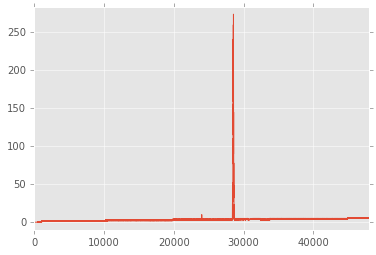

In [219]:
pmtcwf = h5f.root.RD.pmtcwf
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

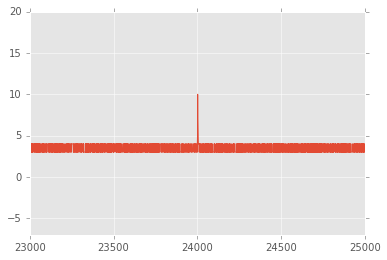

In [222]:
mpl.plts(pmtcwf[2,0], signal_start=23000, signal_end=25000, offset=10)

In [209]:
h5f.close()

In [39]:
pmttwf, sipmtwf, pmtrwf, pmtblr, sipmrwf, pmtdf, sipmdf, gdf, dFEE = tbl.get_vectors(h5f)

In [41]:
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

#### event 0

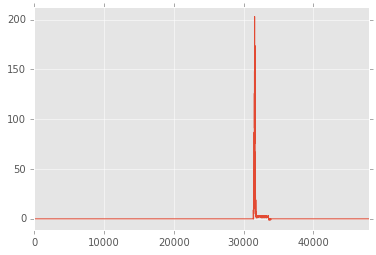

In [42]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

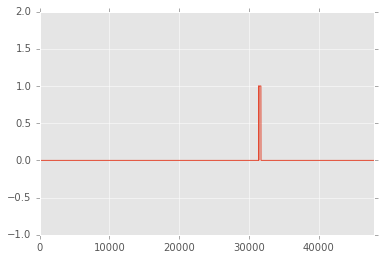

In [43]:
mpl.plts(pulse_on[0], signal_start=0, signal_end=48000, offset=1)

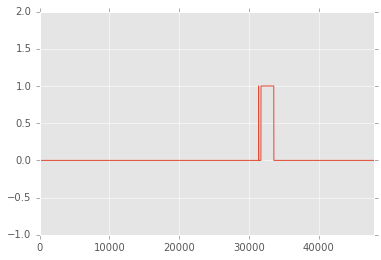

In [44]:
mpl.plts(wait_over[0], signal_start=0, signal_end=48000, offset=1)

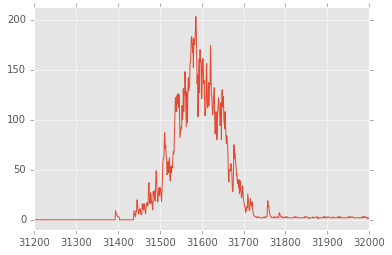

In [46]:
mpl.plts(pmtcwf[0,0], signal_start=31200, signal_end=32000, offset=10)

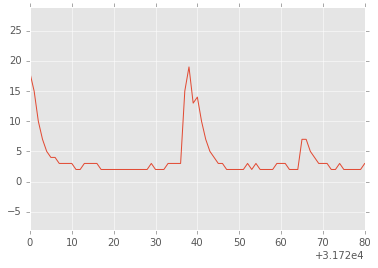

In [48]:
mpl.plts(pmtcwf[0,0], signal_start=31720, signal_end=31800, offset=10)

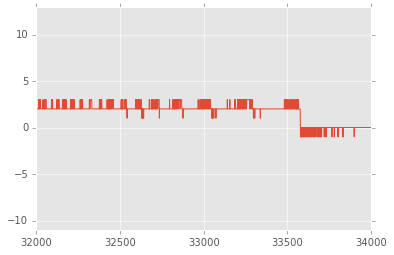

In [49]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=34000, offset=10)

#### event 1

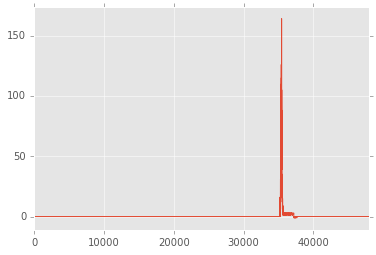

In [253]:
mpl.plts(pmtcwf[1,0], signal_start=0, signal_end=48000, offset=10)

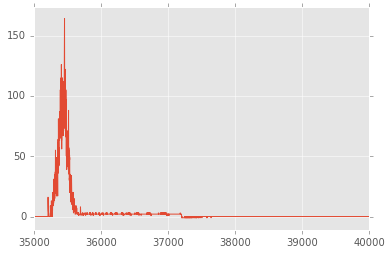

In [254]:
mpl.plts(pmtcwf[1,0], signal_start=35000, signal_end=40000, offset=10)

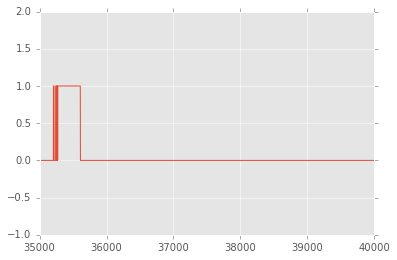

In [260]:
mpl.plts(pulse_on[1], signal_start=35000, signal_end=40000, offset=1)

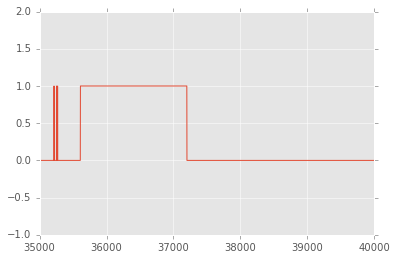

In [261]:
mpl.plts(wait_over[1], signal_start=35000, signal_end=40000, offset=1)

#### event 2

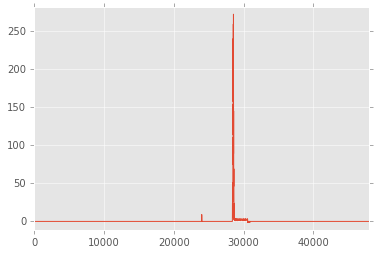

In [244]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

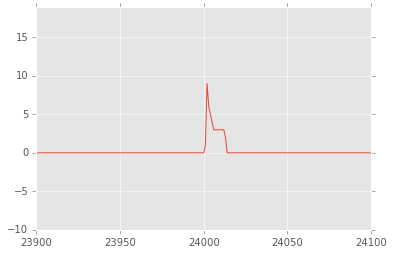

In [243]:
mpl.plts(pmtcwf[2,0], signal_start=23900, signal_end=24100, offset=10)

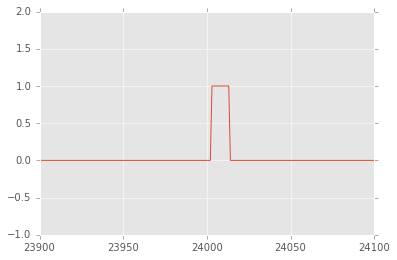

In [263]:
mpl.plts(pulse_on[2], signal_start=23900, signal_end=24100, offset=1)

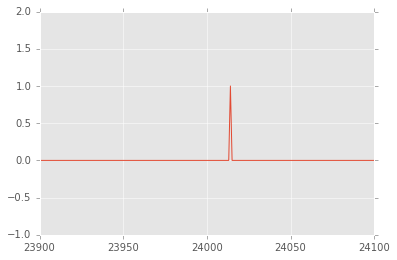

In [264]:
mpl.plts(wait_over[2], signal_start=23900, signal_end=24100, offset=1)

##### Mau

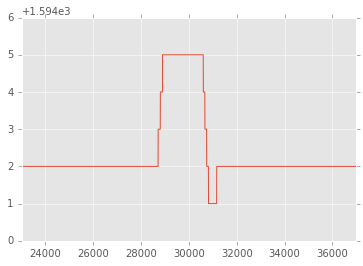

In [245]:
mpl.plts(mau[2], signal_start=23000, signal_end=37000, offset=1)

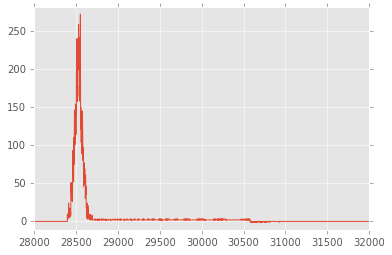

In [266]:
mpl.plts(pmtcwf[2,0], signal_start=28000, signal_end=32000, offset=10)

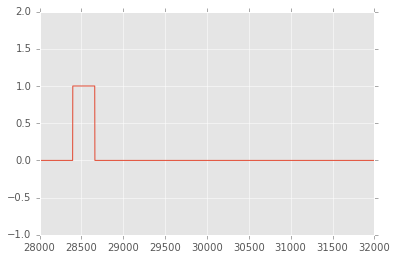

In [267]:
mpl.plts(pulse_on[2], signal_start=28000, signal_end=32000, offset=1)

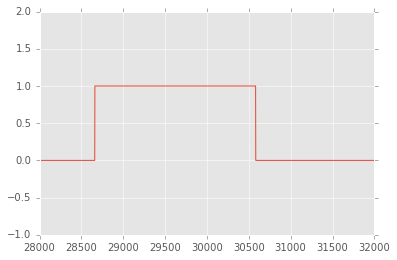

In [268]:
mpl.plts(wait_over[2], signal_start=28000, signal_end=32000, offset=1)

#### event 3

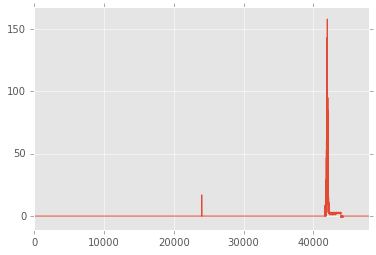

In [275]:
mpl.plts(pmtcwf[3,0], signal_start=0, signal_end=48000, offset=10)

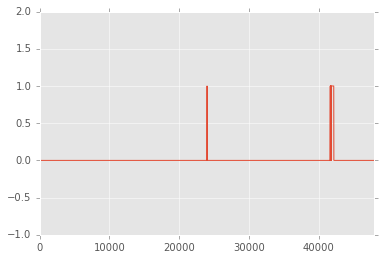

In [273]:
mpl.plts(pulse_on[3], signal_start=0, signal_end=48000, offset=1)

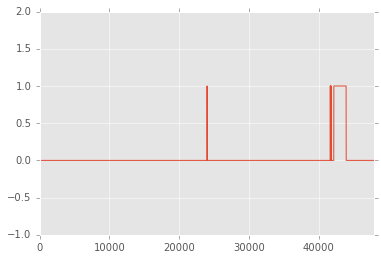

In [274]:
mpl.plts(wait_over[3], signal_start=0, signal_end=48000, offset=1)

#### event 4

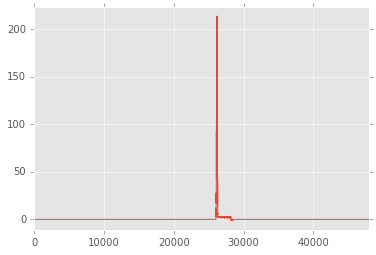

In [279]:
mpl.plts(pmtcwf[4,0], signal_start=0, signal_end=48000, offset=10)

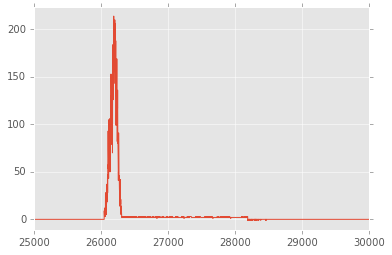

In [280]:
mpl.plts(pmtcwf[4,0], signal_start=25000, signal_end=30000, offset=10)

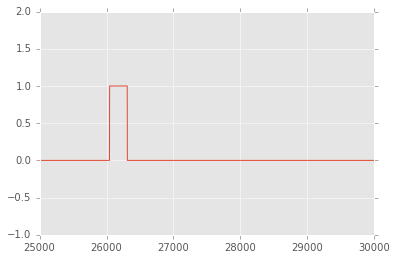

In [281]:
mpl.plts(pulse_on[4], signal_start=25000, signal_end=30000, offset=1)

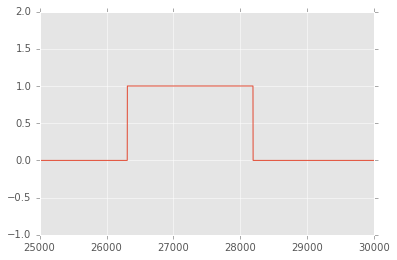

In [282]:
mpl.plts(wait_over[4], signal_start=25000, signal_end=30000, offset=1)

#### event 5

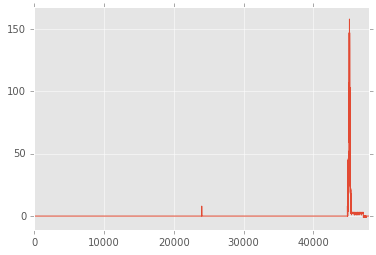

In [290]:
mpl.plts(pmtcwf[5,0], signal_start=0, signal_end=48000, offset=10)

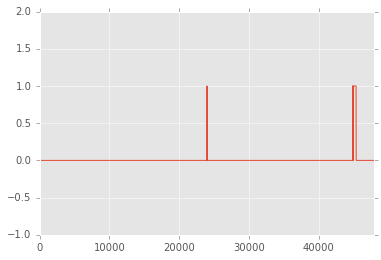

In [291]:
mpl.plts(pulse_on[5], signal_start=0, signal_end=48000, offset=1)

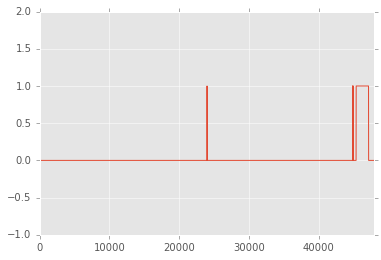

In [292]:
mpl.plts(wait_over[5], signal_start=0, signal_end=48000, offset=1)

#### event 6

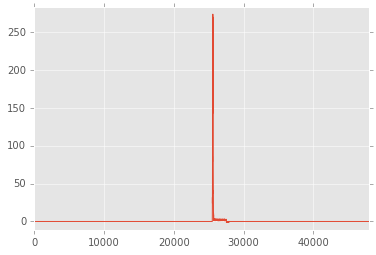

In [283]:
mpl.plts(pmtcwf[6,0], signal_start=0, signal_end=48000, offset=10)

#### event 7

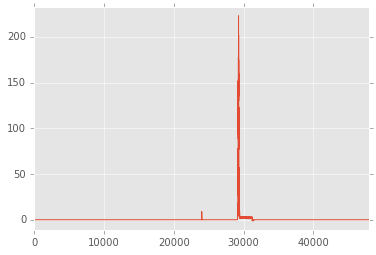

In [284]:
mpl.plts(pmtcwf[7,0], signal_start=0, signal_end=48000, offset=10)

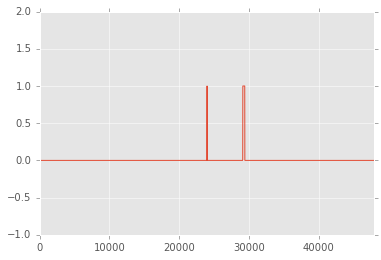

In [286]:
mpl.plts(pulse_on[7], signal_start=0, signal_end=48000, offset=1)

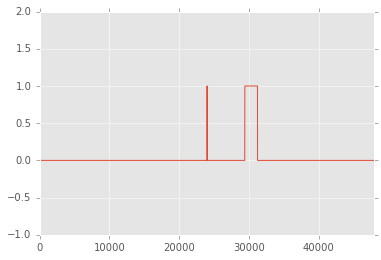

In [287]:
mpl.plts(wait_over[7], signal_start=0, signal_end=48000, offset=1)

#### event 8

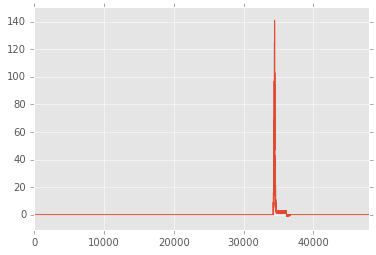

In [288]:
mpl.plts(pmtcwf[8,0], signal_start=0, signal_end=48000, offset=10)

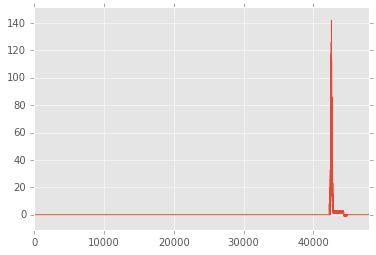

In [289]:
mpl.plts(pmtcwf[9,0], signal_start=0, signal_end=48000, offset=10)

#### Set (2,2,5)

This set of thresholds is stable (we always seem to recover the baseline), but has the annoying side feature of a long pedestal afther the signal is over, at about the same value used for the trheshold. 

#### Set(5,0,2) 

In [51]:
less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [52]:
h5f.close()

In [54]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma2 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 2.99451994896 seconds
Leaving ISIDORA. Safe travels!


In [56]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [57]:
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

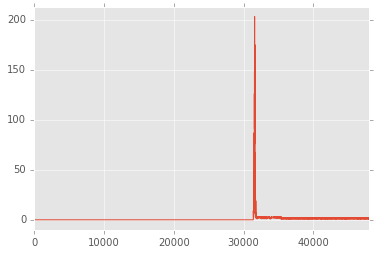

In [58]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

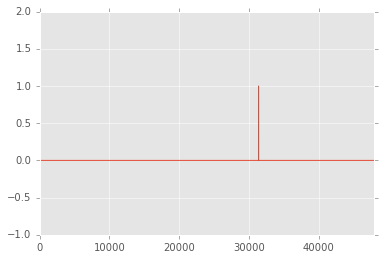

In [59]:
mpl.plts(pulse_on[0], signal_start=0, signal_end=48000, offset=1)

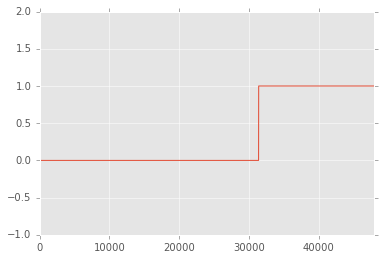

In [60]:
mpl.plts(wait_over[0], signal_start=0, signal_end=48000, offset=1)

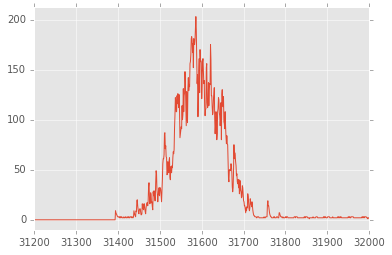

In [61]:
mpl.plts(pmtcwf[0,0], signal_start=31200, signal_end=32000, offset=10)

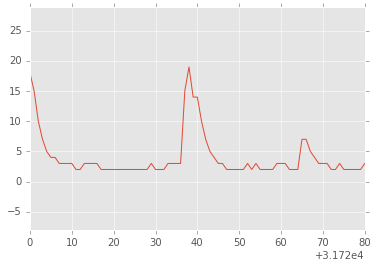

In [62]:
mpl.plts(pmtcwf[0,0], signal_start=31720, signal_end=31800, offset=10)

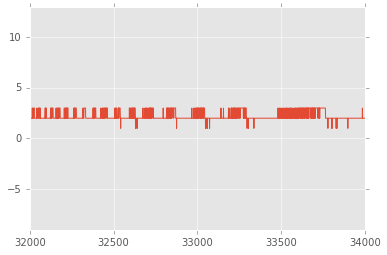

In [63]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=34000, offset=10)

#### We do not recover baseline

#### Set(5,0,3) 

In [64]:
less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [65]:
h5f.close()

In [66]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma2 = 3.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 3.74112010002 seconds
Leaving ISIDORA. Safe travels!


In [68]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [69]:
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

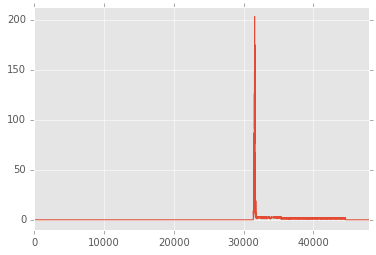

In [70]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

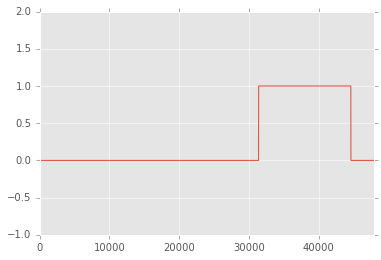

In [71]:
mpl.plts(wait_over[0], signal_start=0, signal_end=48000, offset=1)

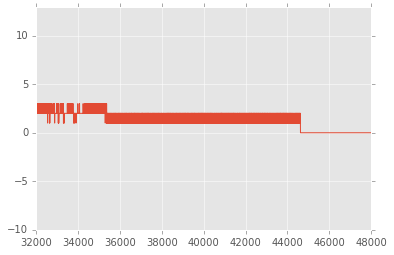

In [73]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=48000, offset=10)

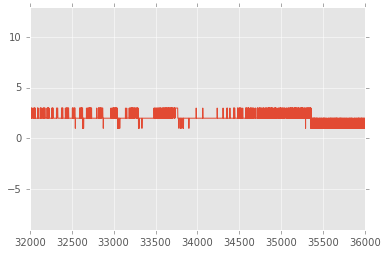

In [74]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=36000, offset=10)

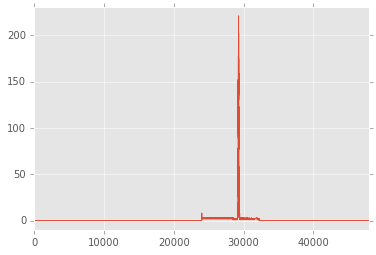

In [75]:
mpl.plts(pmtcwf[7,0], signal_start=0, signal_end=48000, offset=10)

##### Without thr2 we do not recover well S1

##### (3,0,5)

In [84]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [85]:
h5f.close()

In [86]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 0.0 n_sigma2 = 5.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.42155098915 seconds
Leaving ISIDORA. Safe travels!


In [87]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [88]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

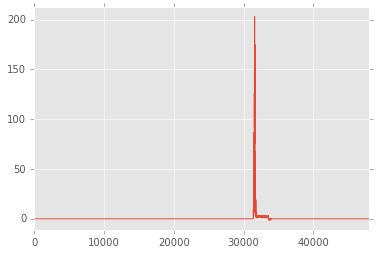

In [89]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

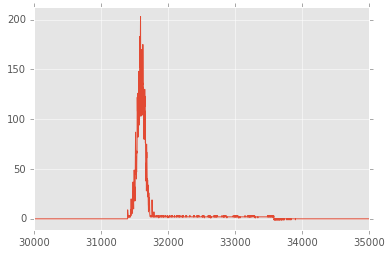

In [98]:
mpl.plts(pmtcwf[0,0], signal_start=30000, signal_end=35000, offset=10)

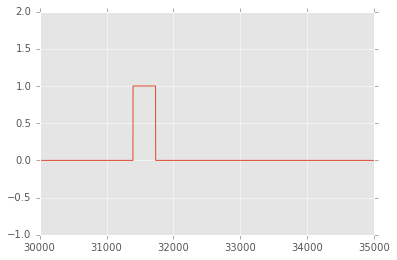

In [100]:
mpl.plts(pulse_on[0], signal_start=30000, signal_end=35000, offset=1)

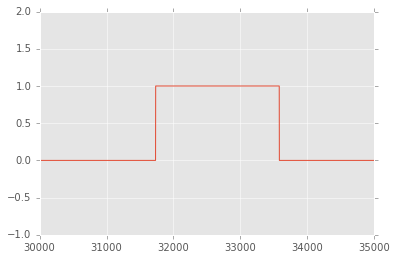

In [101]:
mpl.plts(wait_over[0], signal_start=30000, signal_end=35000, offset=1)

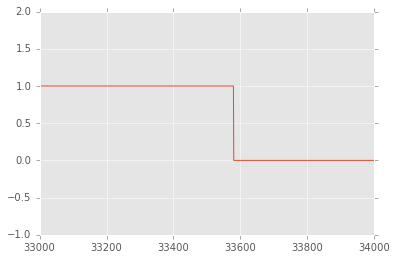

In [102]:
mpl.plts(wait_over[0], signal_start=33000, signal_end=34000, offset=1)

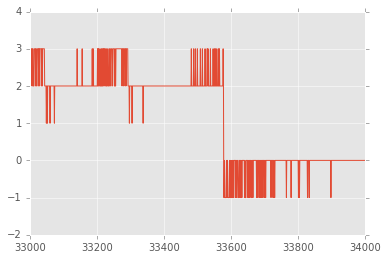

In [103]:
mpl.plts(pmtcwf[0,0], signal_start=33000, signal_end=34000, offset=1)

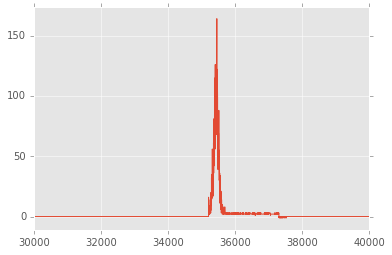

In [105]:
mpl.plts(pmtcwf[1,0], signal_start=30000, signal_end=40000, offset=10)

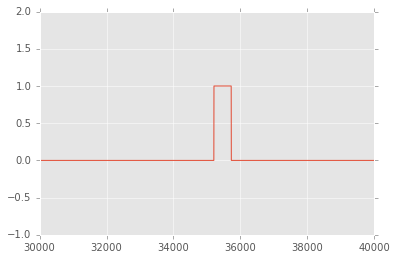

In [106]:
mpl.plts(pulse_on[1], signal_start=30000, signal_end=40000, offset=1)

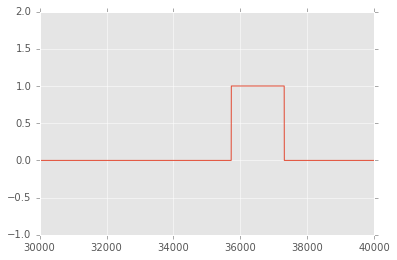

In [108]:
mpl.plts(wait_over[1], signal_start=30000, signal_end=40000, offset=1)

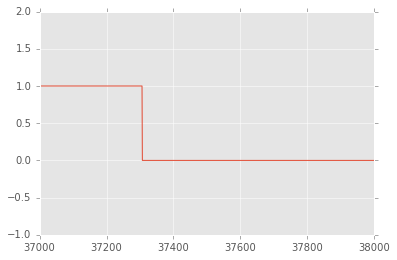

In [109]:
mpl.plts(wait_over[1], signal_start=37000, signal_end=38000, offset=1)

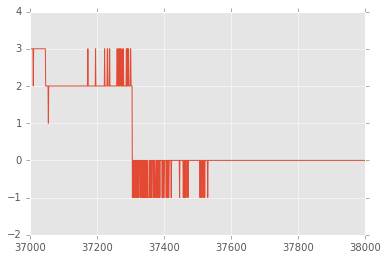

In [110]:
mpl.plts(pmtcwf[1,0], signal_start=37000, signal_end=38000, offset=1)

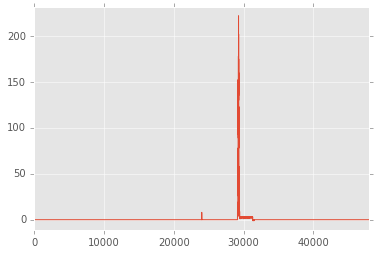

In [113]:
mpl.plts(pmtcwf[7,0], signal_start=0, signal_end=48000, offset=10)

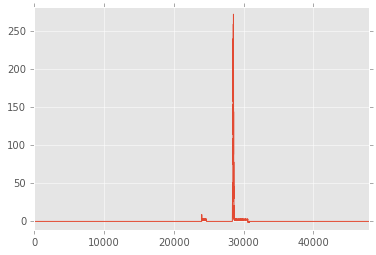

In [114]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

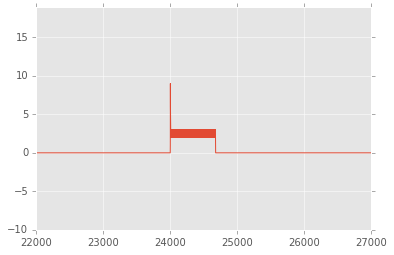

In [115]:
mpl.plts(pmtcwf[2,0], signal_start=22000, signal_end=27000, offset=10)

##### Step in S1

In [116]:
h5f.close()


##### (3,2,5)

In [117]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [118]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 2.0 n_sigma2 = 5.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.50174999237 seconds
Leaving ISIDORA. Safe travels!


In [119]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

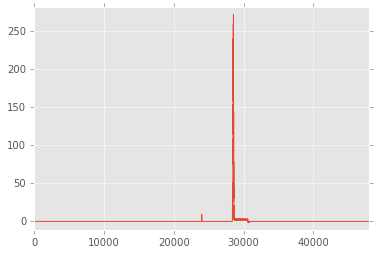

In [120]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

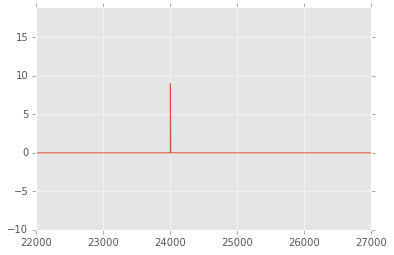

In [121]:
mpl.plts(pmtcwf[2,0], signal_start=22000, signal_end=27000, offset=10)

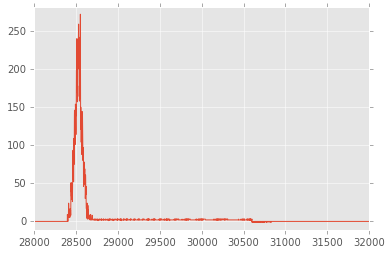

In [123]:
mpl.plts(pmtcwf[2,0], signal_start=28000, signal_end=32000, offset=10)

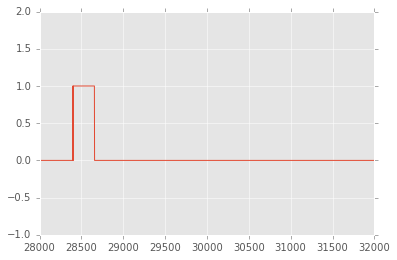

In [125]:
mpl.plts(pulse_on[2], signal_start=28000, signal_end=32000, offset=1)

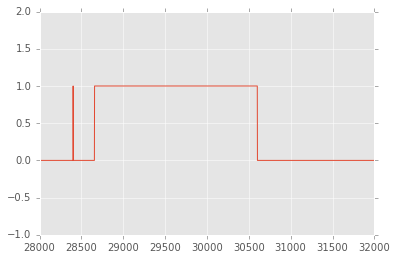

In [126]:
mpl.plts(wait_over[2], signal_start=28000, signal_end=32000, offset=1)

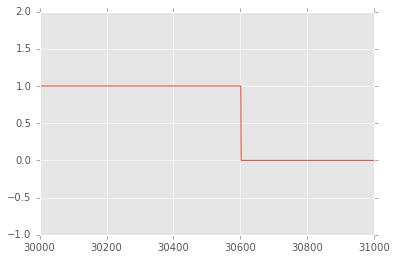

In [127]:
mpl.plts(wait_over[2], signal_start=30000, signal_end=31000, offset=1)

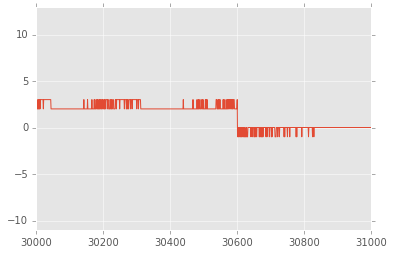

In [128]:
mpl.plts(pmtcwf[2,0], signal_start=30000, signal_end=31000, offset=10)

In [129]:
h5f.close()

In [130]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [131]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 2.0 n_sigma2 = 7.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.51191306114 seconds
Leaving ISIDORA. Safe travels!


In [132]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

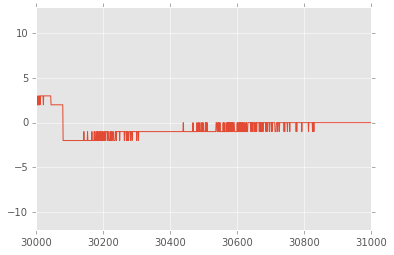

In [133]:
mpl.plts(pmtcwf[2,0], signal_start=30000, signal_end=31000, offset=10)

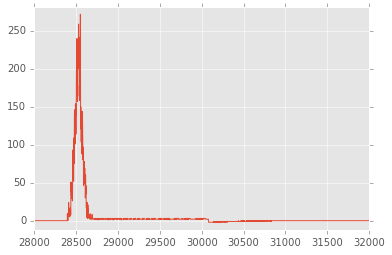

In [134]:
mpl.plts(pmtcwf[2,0], signal_start=28000, signal_end=32000, offset=10)

##### Over compensating! 

In [164]:
h5f.close()

In [136]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [137]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 2.0 n_sigma2 = 3.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.56934094429 seconds
Leaving ISIDORA. Safe travels!


In [138]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

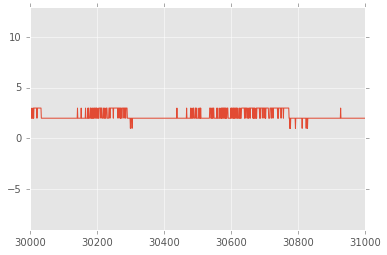

In [139]:
mpl.plts(pmtcwf[2,0], signal_start=30000, signal_end=31000, offset=10)

### Fixing the thresholds
1. th1 = 3 *sigma, to capture correctly the raise of the signal
2. th2 = 2 * sigma, to control recovery of S1 baselines
3. th4 = 5 * sigma to guarantee recovery of S2 baseline

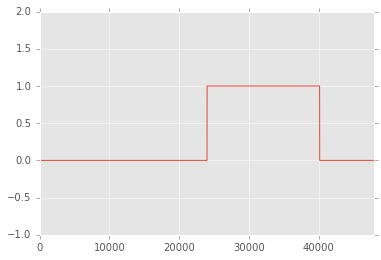

In [144]:
mpl.plts(wait_over[2], signal_start=0, signal_end=48000, offset=1)

##### under compensating! Takes much longer to recover!

## Trying a simple algorithm

### Introducing BLRc

In [42]:
def BLRc(signal_daq, coef, mau_len, thr1 = 0):

    """
    Only for calibration

    """

    len_signal_daq = len(signal_daq)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    pulse_f = np.zeros(len(signal_daq), dtype=np.double)
    
    
    thr = thr1

    #MAU_WindowSize = 40 # provisional
    nm = mau_len
    B_MAU       =   (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    acum[nm] =  MAU[nm]
    BASELINE = MAU[nm-1]

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    signal_r[0:nm] = signal_daq[0:nm] 

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window
    cond = 0

    for k in range(nm,len_signal_daq): 

        trigger_line = MAU[k] + thr

       
        # condition: raw signal raises above trigger line and 
        if (signal_daq[k] > trigger_line) or cond == 1:
            cond = 1
            #offset computed as the value of MAU before pulse starts
            offset = MAU[k-1]  
            
            #update recovered signal, correcting by offset           
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - offset;
                       
    return  signal_r - BASELINE

In [133]:
# %load ../../../Cities/ISIDORA.py
"""
ISIDORA
JJGC Agusut 2016

What ISIDORA does:
1) Reads a RWF file written by DIOMIRA
2) Performs DBLR
3) Write the corrected waveforms (CWF) to the file as new Evectors.

Change Log:
18/10 JJG added cython module
"""

from __future__ import print_function

import sys
from time import time
import numpy as np
import tables

import system_of_units as units
from LogConfig import logger
from Configure import configure, define_event_loop

import FEParam as FP
import FEE2 as FE
import coreFunctions as cf
import cBLR


def accumulator_coefficients(CA,NPMT,len_WF):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    coef_acc = np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        fee = FE.FEE(C=CA[j], R=FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  # inverse function
        coef_acc[j] = signal_inv_daq[10] # any index is valid, function is flat

    return coef_acc


def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """

    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    BLRS =[]

    for j in range(NPMT):
        sgn_raw = FP.ceiling - pmtrd[event_number, j]
        sgn_rec, MAU = BLRc(sgn_raw, coeff_acc[j], mau_len, thr1)
        BLRS.append(sgn_rec)
        
    return np.array(BLRS)


def ISIDORA(argv):
    DEBUG_LEVEL, INFO, CFP = configure(argv[0],argv[1:])

    if INFO:

        print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    PATH_IN = CFP['PATH_IN']
    FILE_IN = CFP['FILE_IN']
    FIRST_EVT = CFP['FIRST_EVT']
    LAST_EVT = CFP['LAST_EVT']
    RUN_ALL = CFP['RUN_ALL']
    COEF = CFP['COEF']
    CA = cf.farray_from_string(CFP['CA'])*units.nF
    AC = cf.farray_from_string(CFP['AC'])
    MAU_LEN = CFP['MAU_LEN']
    NSIGMA1 = CFP['NSIGMA1']
    NSIGMA2 = CFP['NSIGMA2']
    NSIGMA3 = CFP['NSIGMA3']

    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    logger.info("""first event = {} last event = {}
                    nof events requested = {} """.format(FIRST_EVT,
                                                         LAST_EVT,
                                                         NEVENTS))

    logger.info("""MAU length = {}
        n_sigma1 = {} n_sigma2 = {} n_sigma2 = {} """.format(MAU_LEN,
                                                             NSIGMA1,
                                                             NSIGMA2,
                                                             NSIGMA3))
    logger.info("CA  = {} nF ".format(CA/units.nF))
    logger.info("Accumulator Coefficients = {}  ".format(AC))

    # open the input file in mode append
    with tables.open_file("{}/{}".format(PATH_IN, FILE_IN), "a") as h5in:
        # access the PMT raw data in file
        pmtrd_ = h5in.root.RD.pmtrwf     # PMT raw data must exist

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NEVENTS_DST, NPMT, PMTWL = pmtrd_.shape

        logger.info("nof PMTs = {} WF side = {} ".format(NPMT, PMTWL))
        logger.info("nof events in input DST = {} ".format(NEVENTS_DST))

        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        if '/RD/pmtcwf' in h5in:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")

        pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf",
                                atom=tables.Int16Atom(),
                                shape=(0, NPMT, PMTWL),
                                expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration
        # mau, acummulator, pulse_on and wait_over stored for pmt 0
        # baseline stored for all PMTs.
        

        # compute the accumulator coefficients from the nominal values
        # of capacitances (if COEF =0) or use previously computed coeff
        coeff_acc = accumulator_coefficients(CA,
                                             NPMT, PMTWL) if COEF == 0 else AC

        # LOOP
        first_evt, last_evt = define_event_loop(FIRST_EVT, LAST_EVT,
                                                NEVENTS, NEVENTS_DST, RUN_ALL)

        t0 = time()
        for i in range(first_evt,last_evt):

            logger.info("-->event number ={}".format(i))
            signal_r = DBLR(pmtrd_, i, coeff_acc, mau_len=500, thr1 = NSIGMA1*FP.NOISE_ADC)
            # append to pmtcwd
            pmtcwf.append(signal_r.reshape(1, NPMT, PMTWL))

        t1 = time()
        pmtcwf.flush()

        print("ISIDORA has run over {} events in {} seconds".format(i+1,
                                                                    t1-t0))
    print("Leaving ISIDORA. Safe travels!")

#if __name__ == '__main__':

#    ISIDORA(sys.argv)


In [191]:
h5f.close()

In [166]:
ISIDORA(['ISIDORA','-d','INFO','-c''../../../Config/ISIDORA_NA_ZLIB_test2.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


INFO:root:first event = 0 last event = 10
                    nof events requested = 10 


first event = 0 last event = 10
                    nof events requested = 10 


INFO:root:MAU length = 250
        n_sigma1 = 2.0 n_sigma2 = 2.0 n_sigma2 = 5.0 


MAU length = 250
        n_sigma1 = 2.0 n_sigma2 = 2.0 n_sigma2 = 5.0 


INFO:root:CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


INFO:root:Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


INFO:root:nof PMTs = 12 WF side = 48000 


nof PMTs = 12 WF side = 48000 


INFO:root:nof events in input DST = 10 


nof events in input DST = 10 


INFO:root:-->event number =0


-->event number =0


1596.51599121
trigger at k = 500, offset = 1596.51599121, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 11000

-->event number =1


1596.49597168
trigger at k = 500, offset = 1596.49597168, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 11000

-->event number =2


1596.4420166
trigger at k = 500, offset = 1596.4420166, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 11000 t

-->event number =3


1596.48400879
trigger at k = 500, offset = 1596.48400879, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 11000

-->event number =4


1596.52001953
trigger at k = 500, offset = 1596.52001953, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 11000

-->event number =5


1596.52197266
trigger at k = 500, offset = 1596.52197266, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 11000

-->event number =6


1596.49194336
trigger at k = 500, offset = 1596.49194336, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 11000

-->event number =7


1596.52197266
trigger at k = 500, offset = 1596.52197266, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 11000

-->event number =8


1596.49401855
trigger at k = 500, offset = 1596.49401855, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 11000

-->event number =9


1596.5279541
trigger at k = 500, offset = 1596.5279541, accum = 0.0
k = 1000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 2000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 3000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 4000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 5000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 6000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 7000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 8000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1597 signal_r = 0.0
k = 9000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 10000 trigger_line = 1.53600001335 pulse_on = 1 MAU = 0.0 signal_d = 1596 signal_r = 0.0
k = 11000 t

In [192]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf = h5f.root.RD.pmtcwf

In [136]:
pmtrwf = h5f.root.RD.pmtrwf

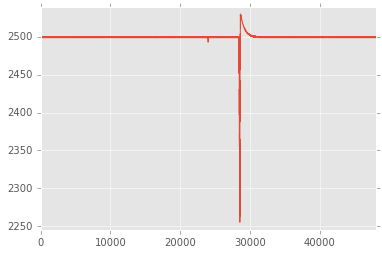

In [137]:
mpl.plts(pmtrwf[2,0], signal_start=0, signal_end=48000, offset=10)

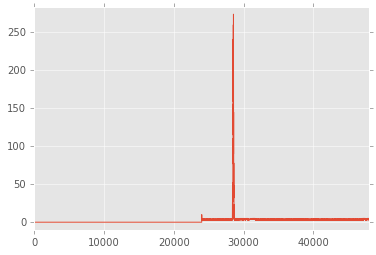

In [193]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

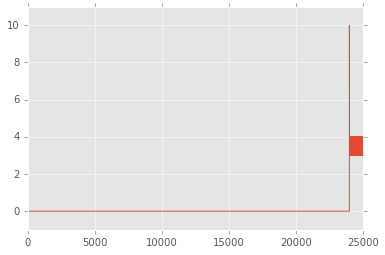

In [194]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=25000, offset=1)

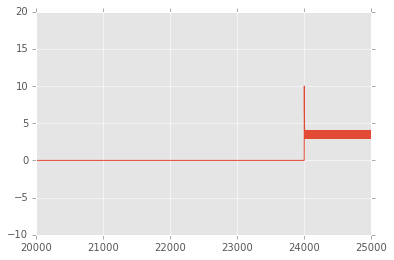

In [195]:
mpl.plts(pmtcwf[2,0], signal_start=20000, signal_end=25000, offset=10)

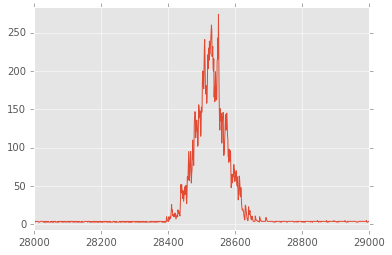

In [196]:
mpl.plts(pmtcwf[2,0], signal_start=28000, signal_end=29000, offset=10)

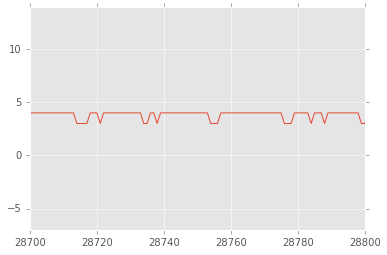

In [197]:
mpl.plts(pmtcwf[2,0], signal_start=28700, signal_end=28800, offset=10)

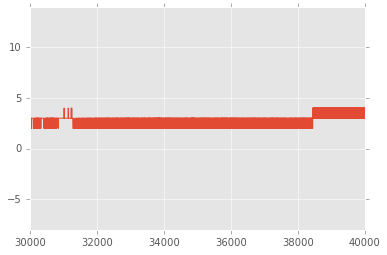

In [143]:
mpl.plts(pmtcwf[2,0], signal_start=30000, signal_end=40000, offset=10)

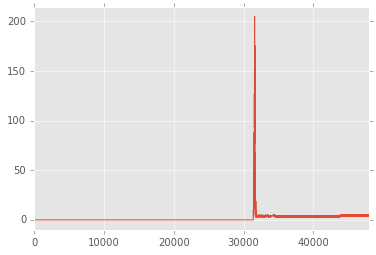

In [198]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

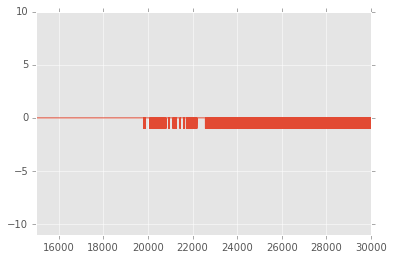

In [145]:
mpl.plts(pmtcwf[0,0], signal_start=15000, signal_end=30000, offset=10)

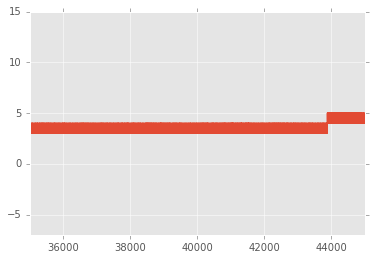

In [199]:
mpl.plts(pmtcwf[0,0], signal_start=35000, signal_end=45000, offset=10)

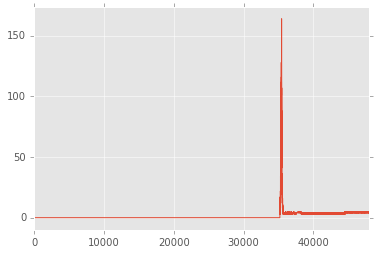

In [200]:
mpl.plts(pmtcwf[1,0], signal_start=0, signal_end=48000, offset=10)

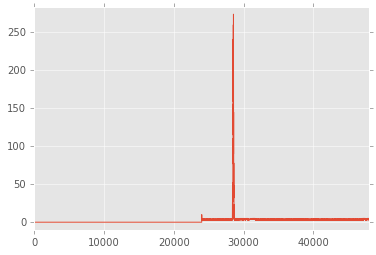

In [201]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

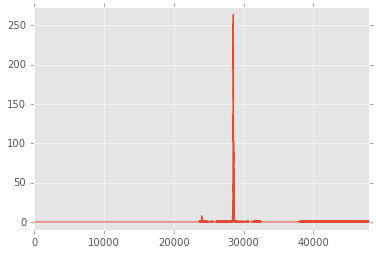

In [149]:
mpl.plts(pmtcwf[2,1], signal_start=0, signal_end=48000, offset=10)

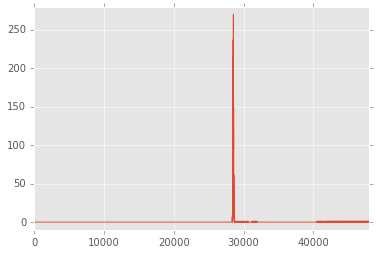

In [150]:
mpl.plts(pmtcwf[2,2], signal_start=0, signal_end=48000, offset=10)

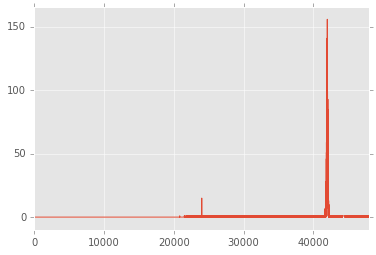

In [151]:
mpl.plts(pmtcwf[3,0], signal_start=0, signal_end=48000, offset=10)

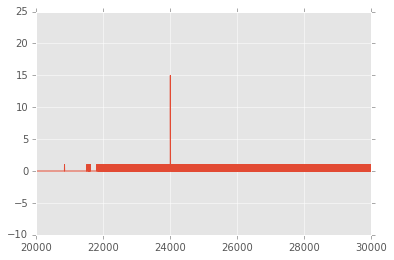

In [152]:
mpl.plts(pmtcwf[3,0], signal_start=20000, signal_end=30000, offset=10)

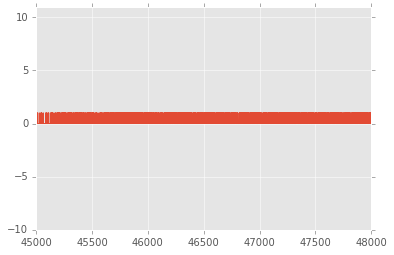

In [153]:
mpl.plts(pmtcwf[3,0], signal_start=45000, signal_end=48000, offset=10)

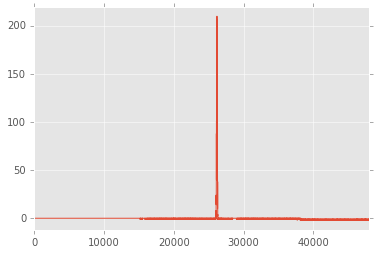

In [154]:
mpl.plts(pmtcwf[4,0], signal_start=0, signal_end=48000, offset=10)

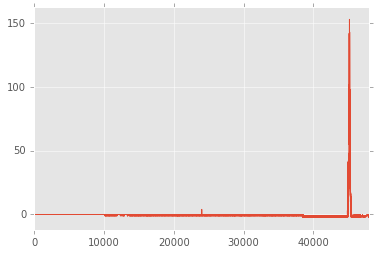

In [155]:
mpl.plts(pmtcwf[5,0], signal_start=0, signal_end=48000, offset=10)

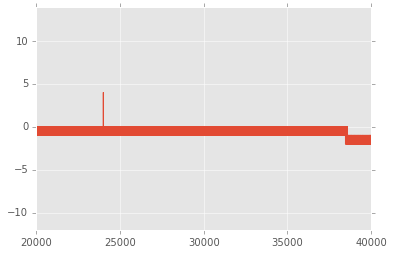

In [156]:
mpl.plts(pmtcwf[5,0], signal_start=20000, signal_end=40000, offset=10)

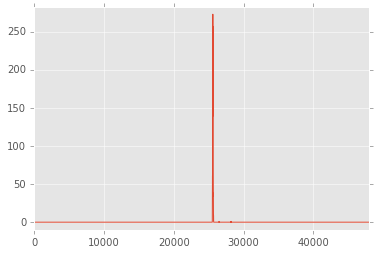

In [157]:
mpl.plts(pmtcwf[6,0], signal_start=0, signal_end=48000, offset=10)

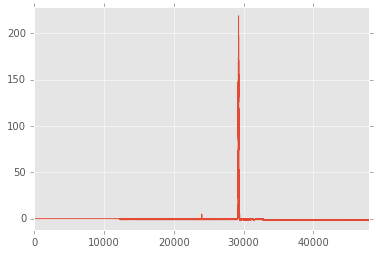

In [158]:
mpl.plts(pmtcwf[7,0], signal_start=0, signal_end=48000, offset=10)

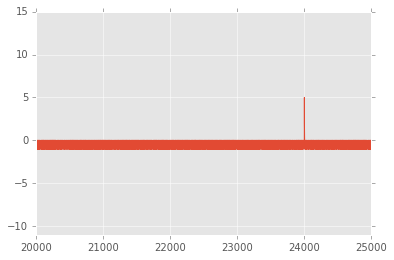

In [159]:
mpl.plts(pmtcwf[7,0], signal_start=20000, signal_end=25000, offset=10)

### Understanding the BLR parameters

The BLR algorithm is controlled by 3 threshold:
1. thr1 controls when the pulse starts and (together with thr2) where the pulse ends:
2. thr3 controls when the raw signal reaches baseline
3. thr2 is an auxiliare threshold helps to control convergence. 

In more detail, thr1 works as follows

Once pulse_on = 1 the BLR algorithm freezes the MAU (the baseline) and starts recovering signal

The pulse finishes (pulse_on = 0) when the recovered signal falls below trigger line (which is controlled by the baseline and thr2).

Tail compensation is needed to recover the baseline as soon as possible, since another signal can come at any time, but once the recovered signal has dropped below trigger line its energy is fixed. The tail compensation condition is as follows:

If thr3 is zero or too low, often the tail never compensates. Setting it sufficiently large forces the signal to return to baseline, sometimes with a small jump (which should be irrelevant, since the recovered signal is over).

### Tuning parameters

#### "old" Na-22 file

#### thr1 = 5 x sigma, thr2 = 0 x sigma, thr3 = 0 x sigma

In [304]:
h5f.close()

In [306]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 0.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 2.45076179504 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 2.43 s, sys: 38.6 ms, total: 2.47 s
Wall time: 2.52 s


In [313]:
def cwf(event=0, pmt=0):
    h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_evt1000_RWF.h5', "r+") 
    pmtcwf = h5f.root.RD.pmtcwf
    pmtcw = pmtcwf[event, pmt]
    pulse_on = h5f.root.BLR.pulse_on[event]
    wait_over = h5f.root.BLR.wait_over[event]
    acum  = h5f.root.BLR.acum[event] 
    plts(pmtcw, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(pulse_on, signal_start=0, signal_end=25000, offset=1)
    plts(wait_over, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=0, signal_end=2000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=5000, signal_end=5500, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=5700, signal_end=7000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=6000, signal_end=9000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=0, signal_end=2000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=7500, signal_end=9000, offset=1)
    plt.show()
    h5f.close()
    

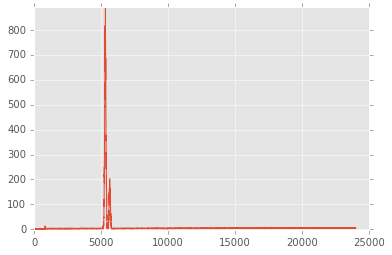

Press a key...


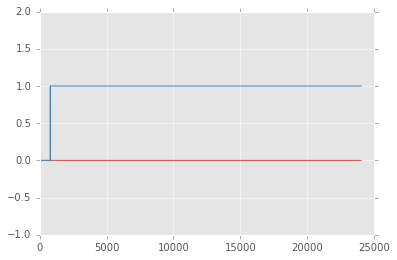

Press a key...


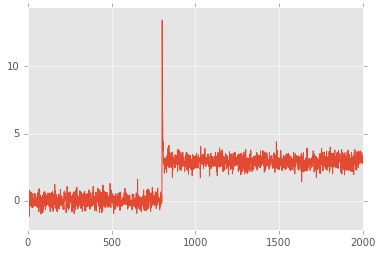

Press a key...


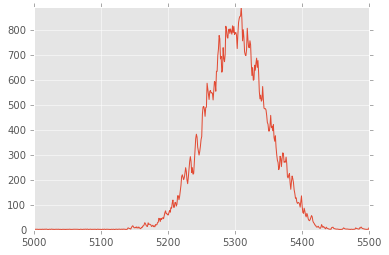

Press a key...


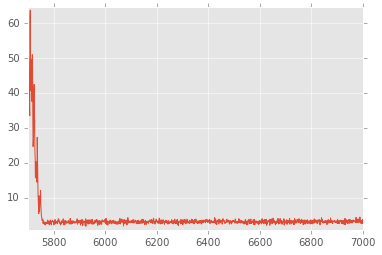

Press a key...


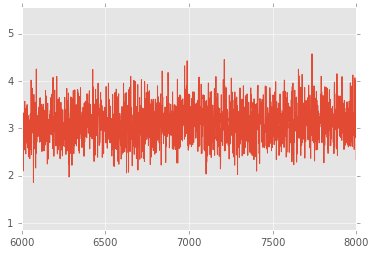

Press a key...


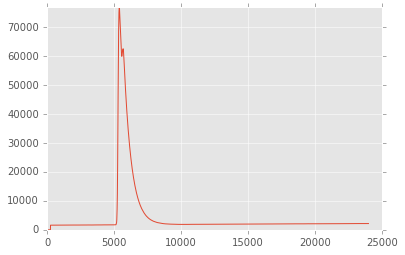

Press a key...


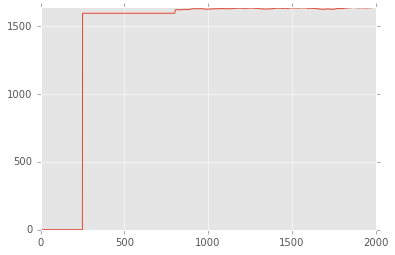

Press a key...


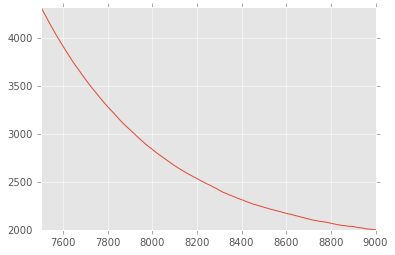

In [308]:
cwf()

#### With nsigma (5,0,0)  the baseline is never fully recovered

### Case (5,0,1)

In [309]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 1.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 2.9679889679 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 2.97 s, sys: 37.9 ms, total: 3.01 s
Wall time: 3.03 s


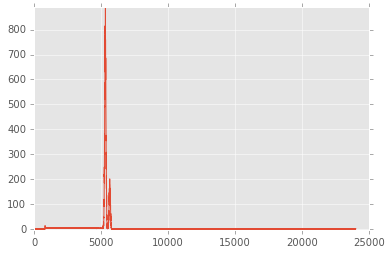

Press a key...


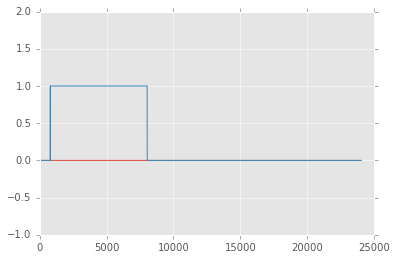

Press a key...


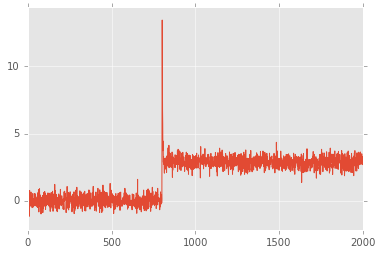

Press a key...


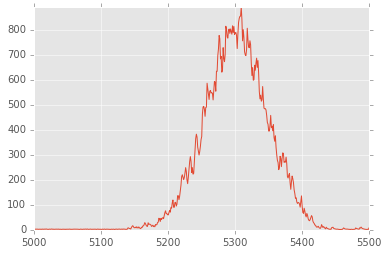

Press a key...


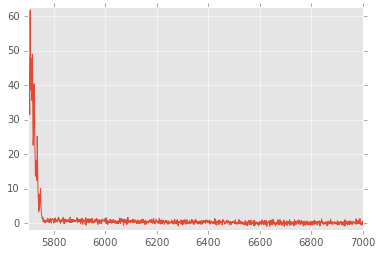

Press a key...


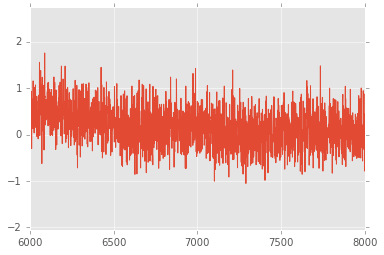

Press a key...


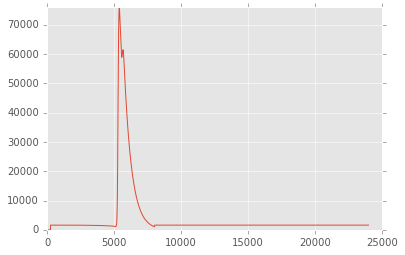

Press a key...


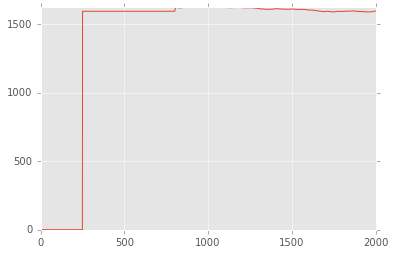

Press a key...


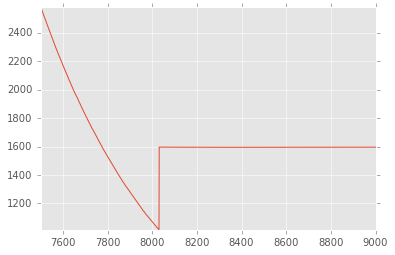

In [310]:
cwf()

#### Case (5,0,1):  The baseline returns to zero by S1 is distorted.

###  Case(5,0,2)

In [311]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 3.0748860836 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 3.07 s, sys: 40.8 ms, total: 3.11 s
Wall time: 3.14 s


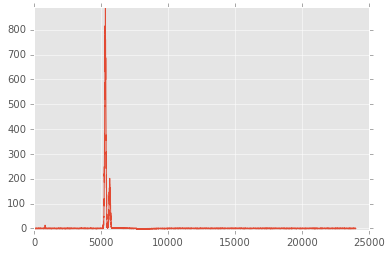

Press a key...


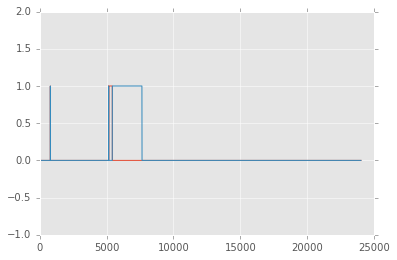

Press a key...


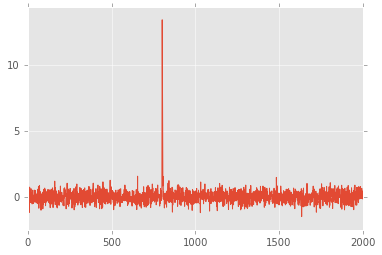

Press a key...


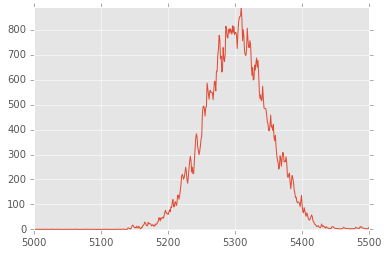

Press a key...


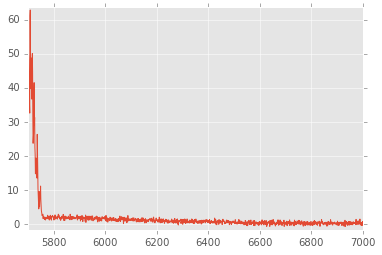

Press a key...


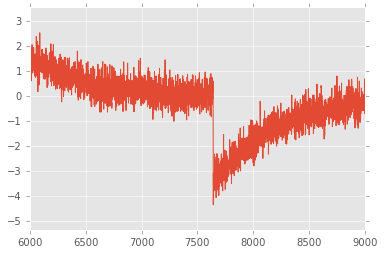

Press a key...


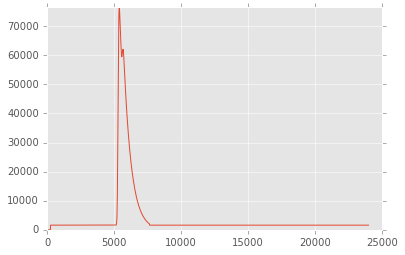

Press a key...


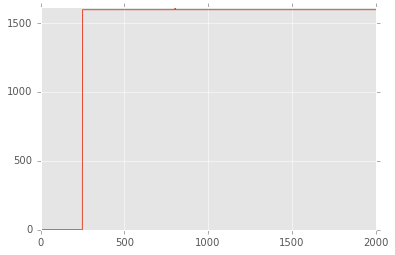

Press a key...


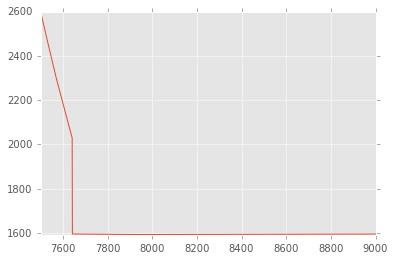

In [314]:
cwf()

### C(5,0,2): S1 is not distorted, wait_over is minimized.

### Test run over 10 events

In [315]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 10 nof events requested = 10 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


ISIDORA has run over 9 events in 31.8485651016 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 31.1 s, sys: 455 ms, total: 31.6 s
Wall time: 32 s


In [316]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_evt1000_RWF.h5', "r+") 
pmtcwf = h5f.root.RD.pmtcwf

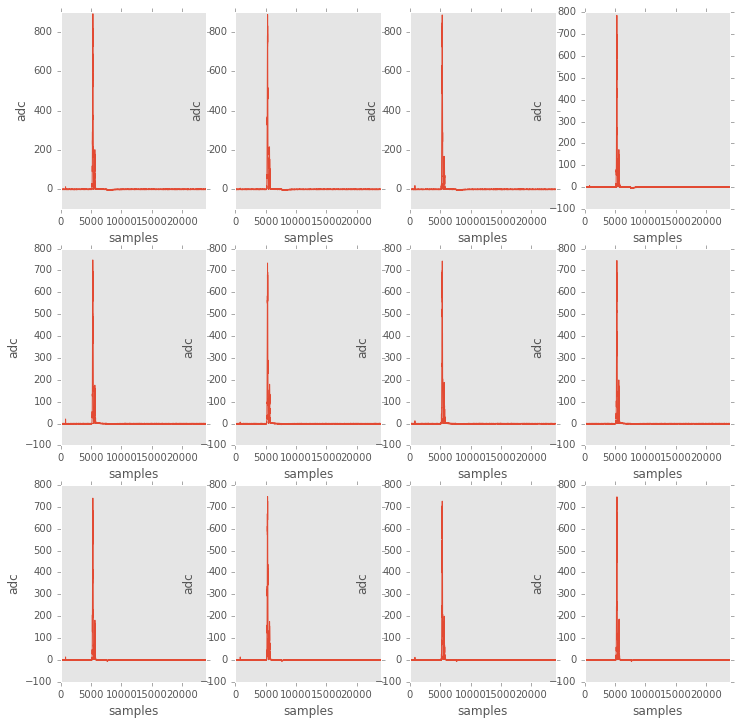

Press a key...


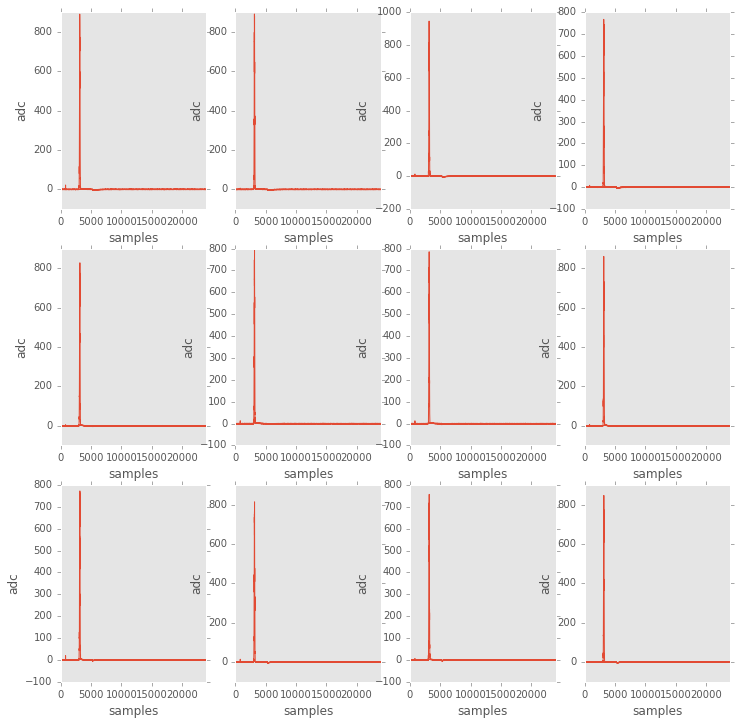

Press a key...


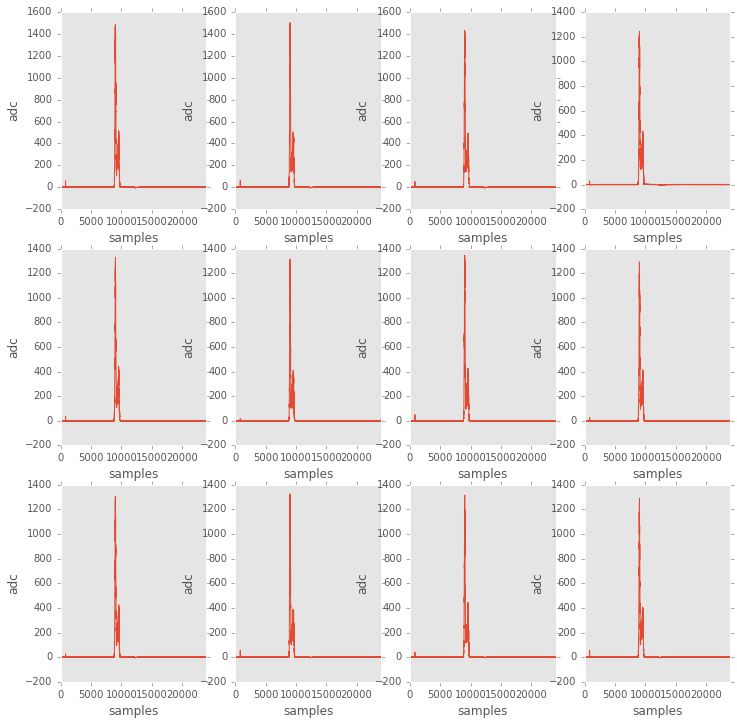

Press a key...


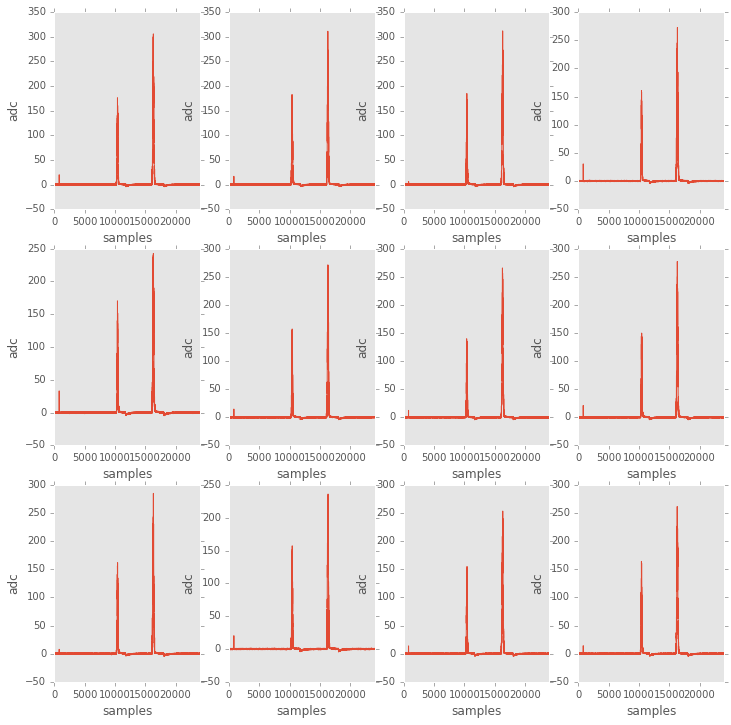

Press a key...


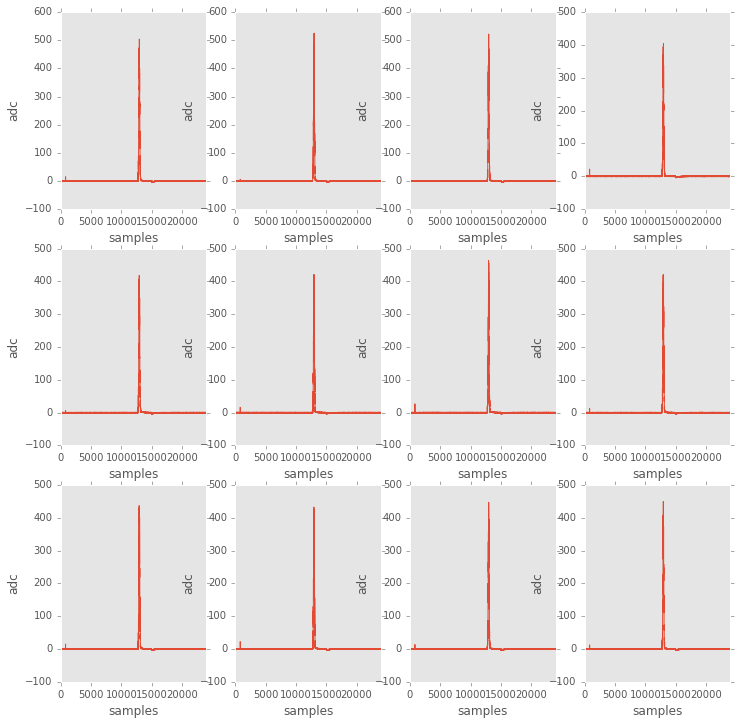

Press a key...


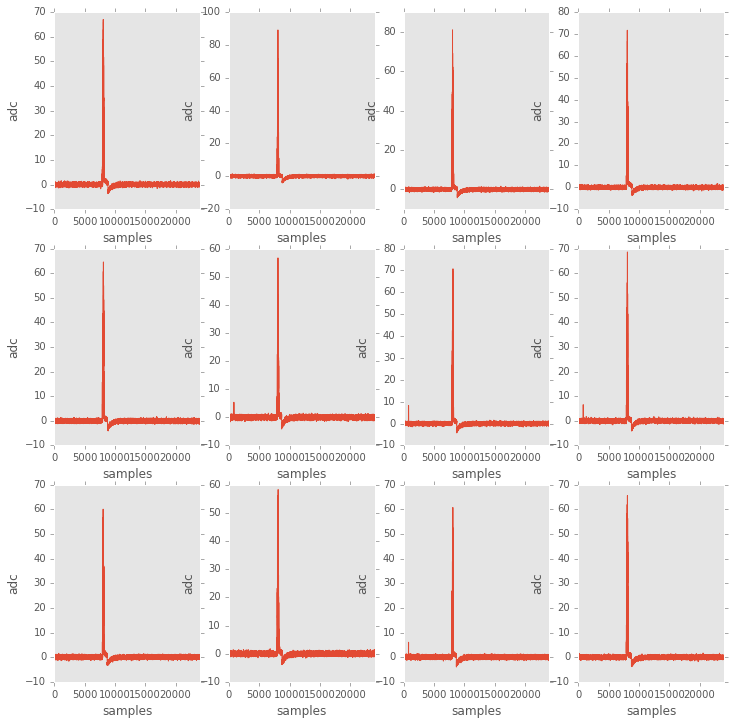

Press a key...


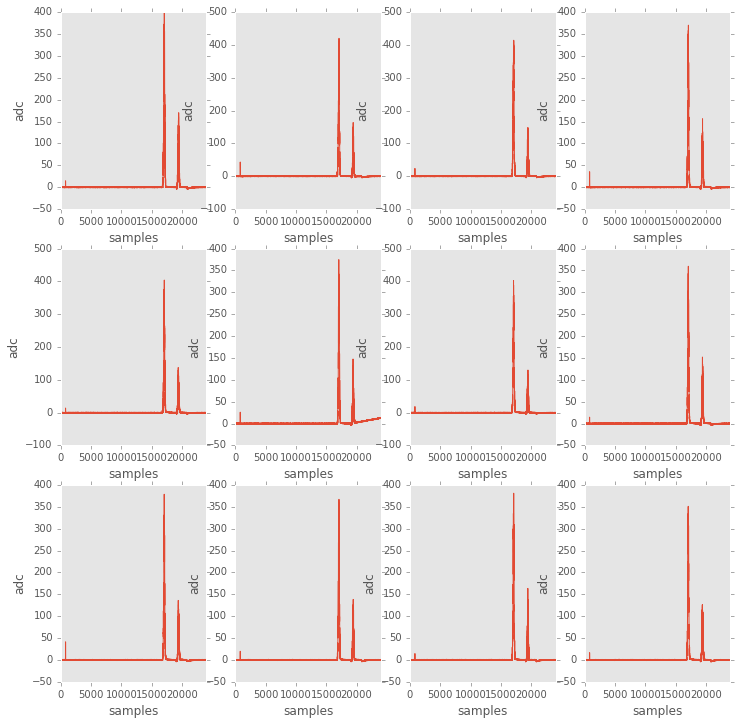

Press a key...


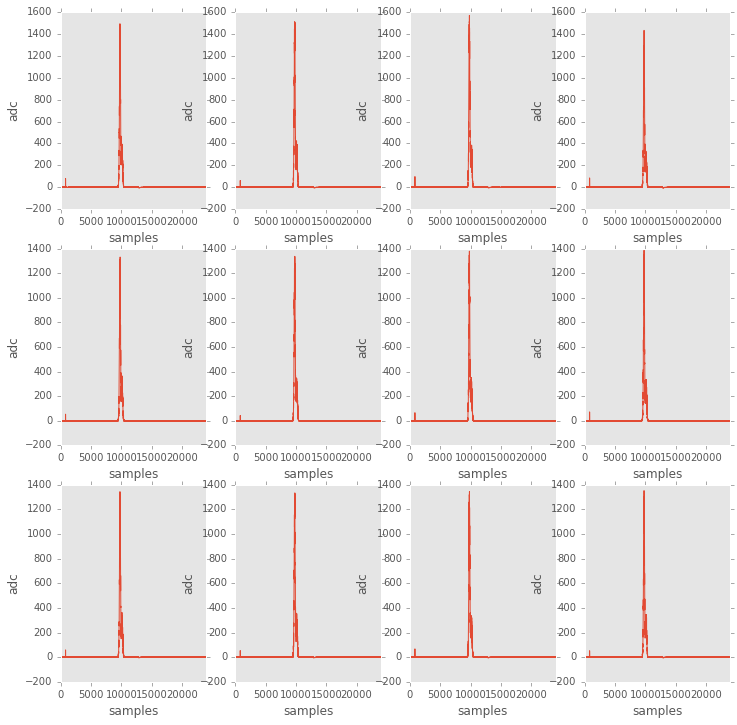

Press a key...


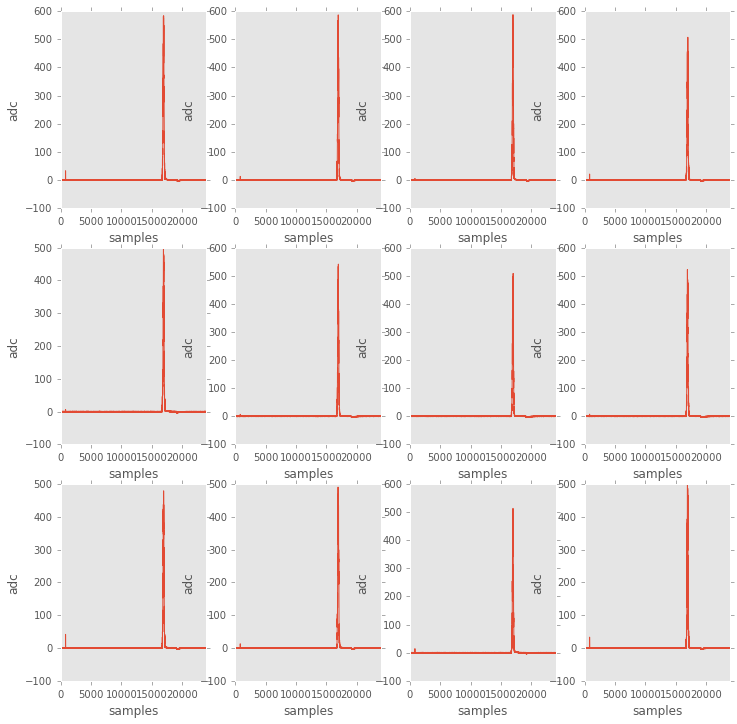

Press a key...


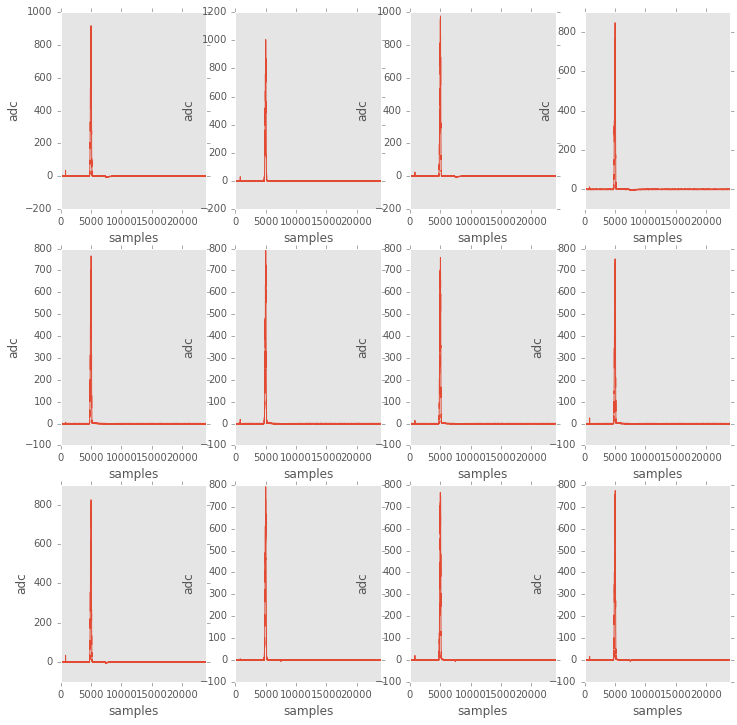

Press a key...


In [317]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(10))

### Test run over new preproc Kr file

In [320]:
h5f.close()

In [322]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5','r+')

In [323]:
pmtrwf = h5f.root.RD.pmtrwf

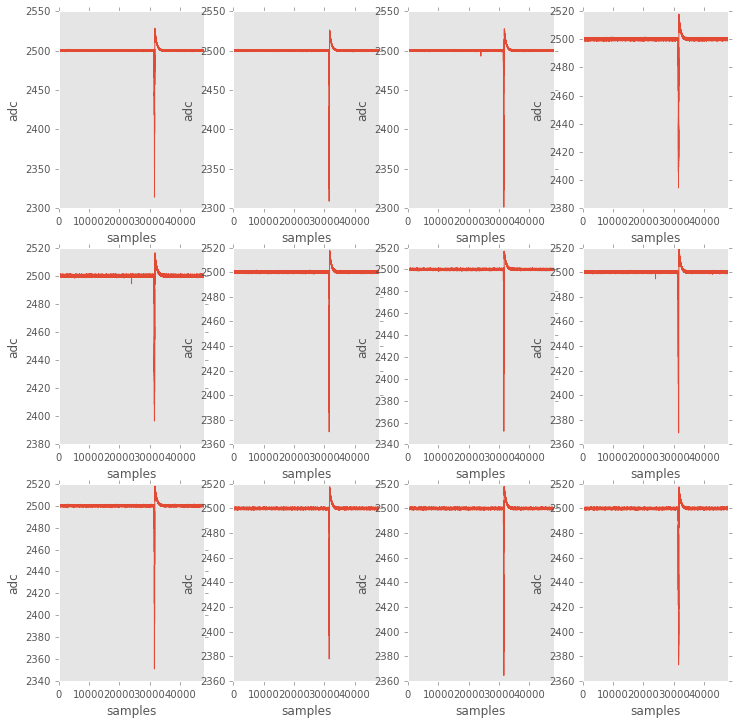

Press a key...


In [324]:
mpl.scan_waveforms(pmtrwf,list_of_events=[0])

In [325]:
h5f.close()

In [326]:
%less ../../Config/ISIDORA_NA_ZLIB_test.csv

### C(5,0,2)

In [346]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_ACTIVE_5bar_evt_1000.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 48000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 6.16009998322 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 6.13 s, sys: 119 ms, total: 6.25 s
Wall time: 6.26 s


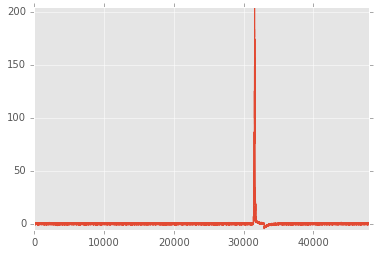

In [347]:
h5f.close()
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5', "r+")
pmtcwf = h5f.root.RD.pmtcwf
pulse_on = h5f.root.BLR.pulse_on[0]
wait_over = h5f.root.BLR.wait_over[0]
acum  = h5f.root.BLR.acum[0] 
pmtcw = pmtcwf[0, 0]
plts(pmtcw, signal_start=0, signal_end=48000, offset=1)

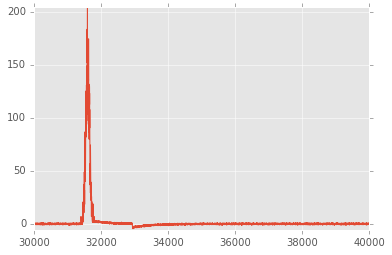

In [349]:
plts(pmtcw, signal_start=30000, signal_end=40000, offset=1)

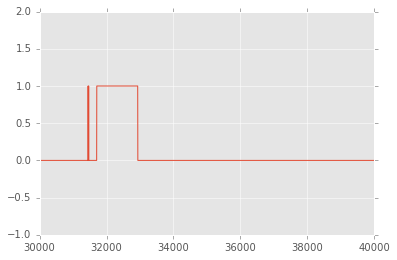

In [350]:
plts(wait_over, signal_start=30000, signal_end=40000, offset=1)

### Running 10 events

In [351]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_ACTIVE_5bar_evt_1000.h5 
first event = 0 last event = 10 nof events requested = 10 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 48000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


ISIDORA has run over 9 events in 61.3548669815 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 1min, sys: 799 ms, total: 1min 1s
Wall time: 1min 1s


In [353]:
h5f.close()
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5', "r+")
pmtcwf = h5f.root.RD.pmtcwf

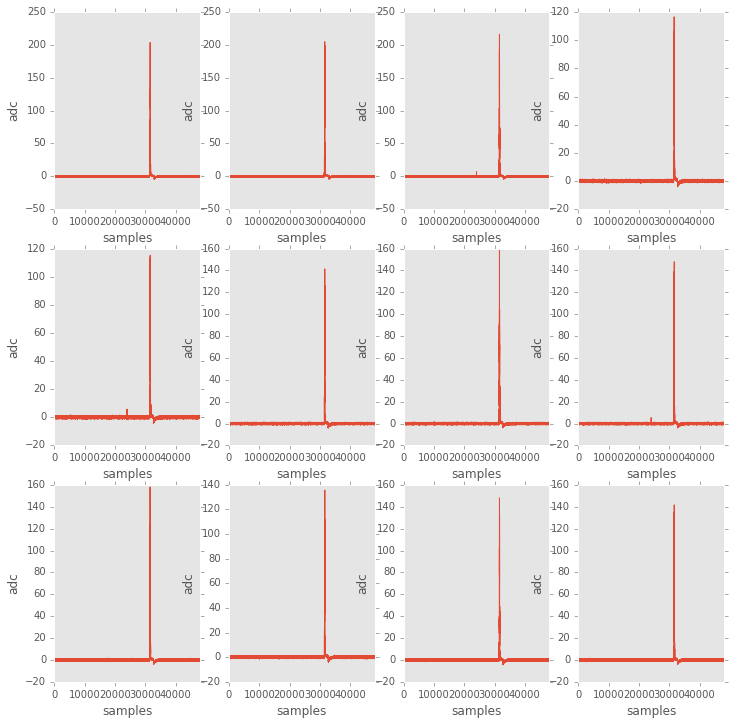

Press a key...


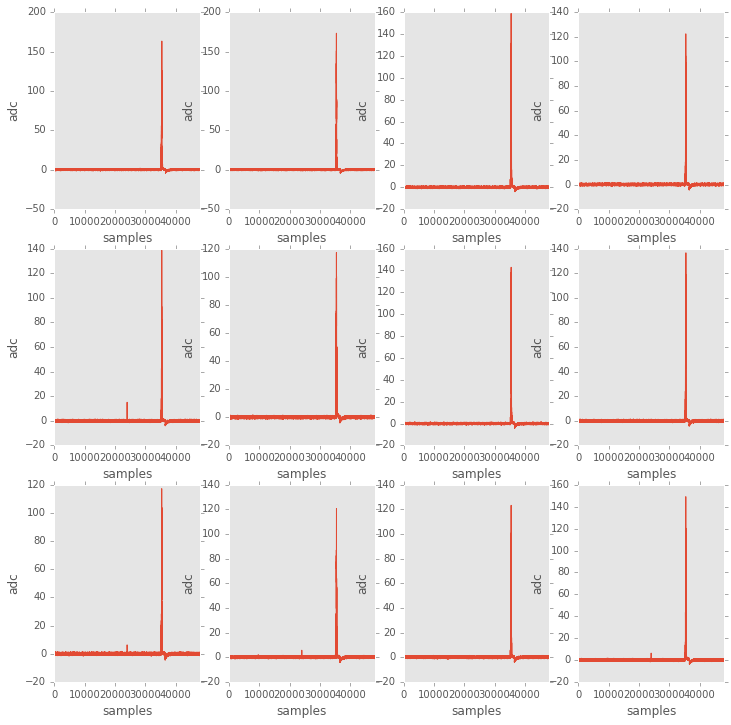

Press a key...


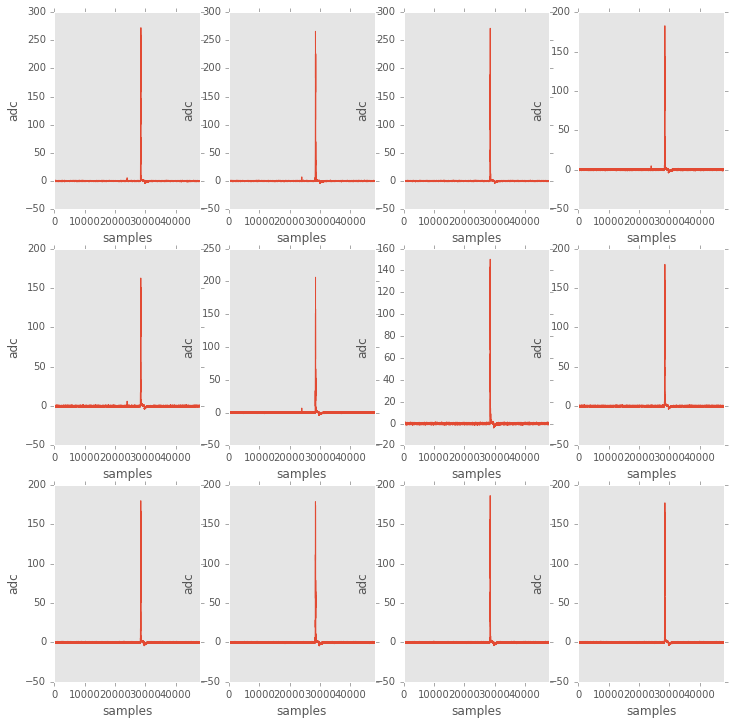

Press a key...


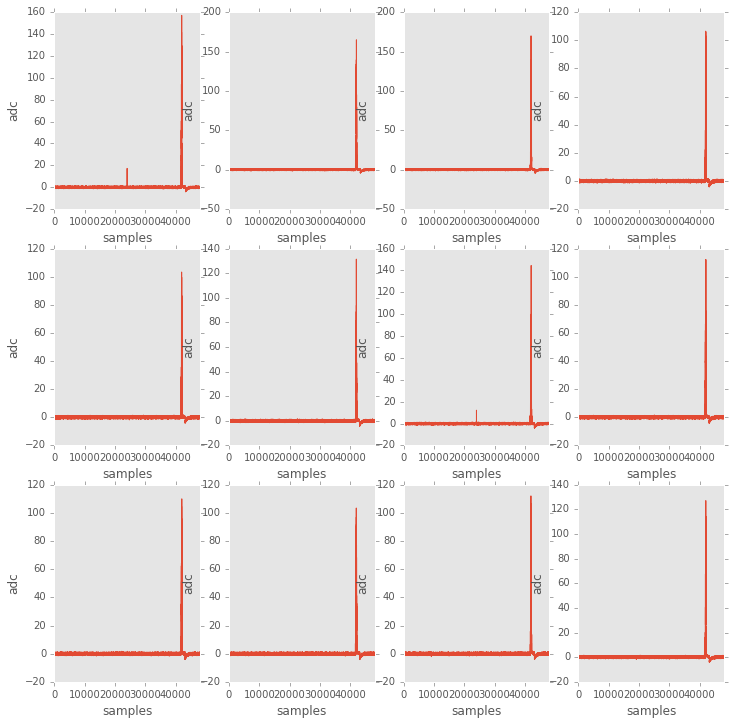

Press a key...


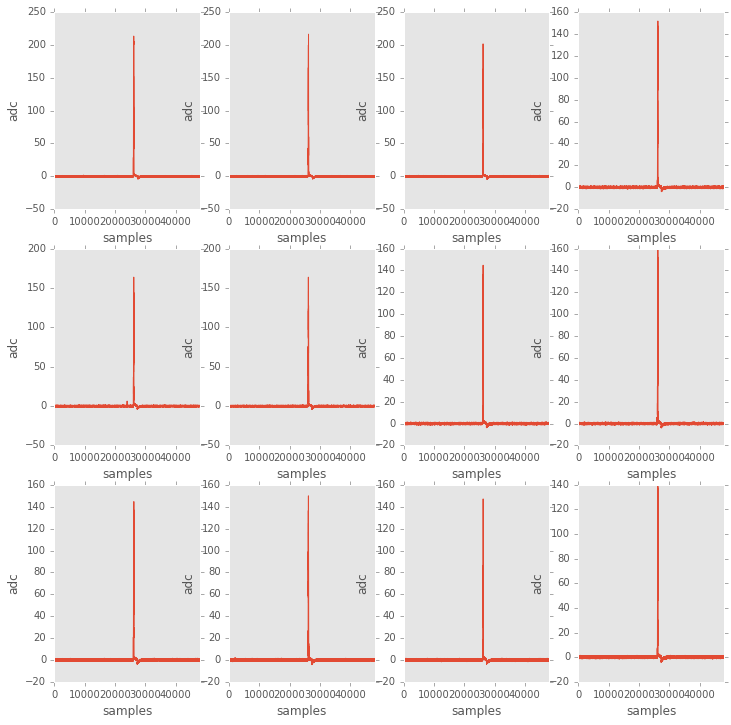

Press a key...


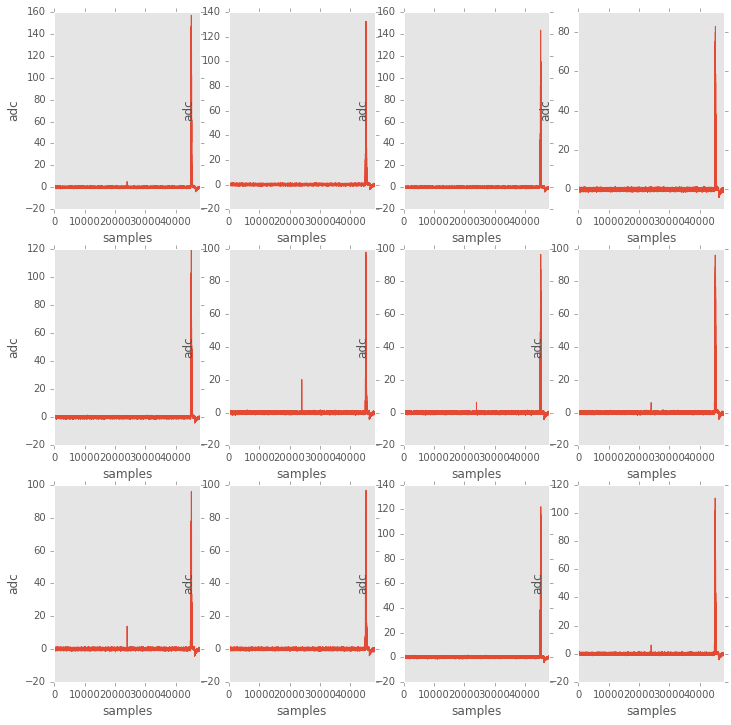

Press a key...


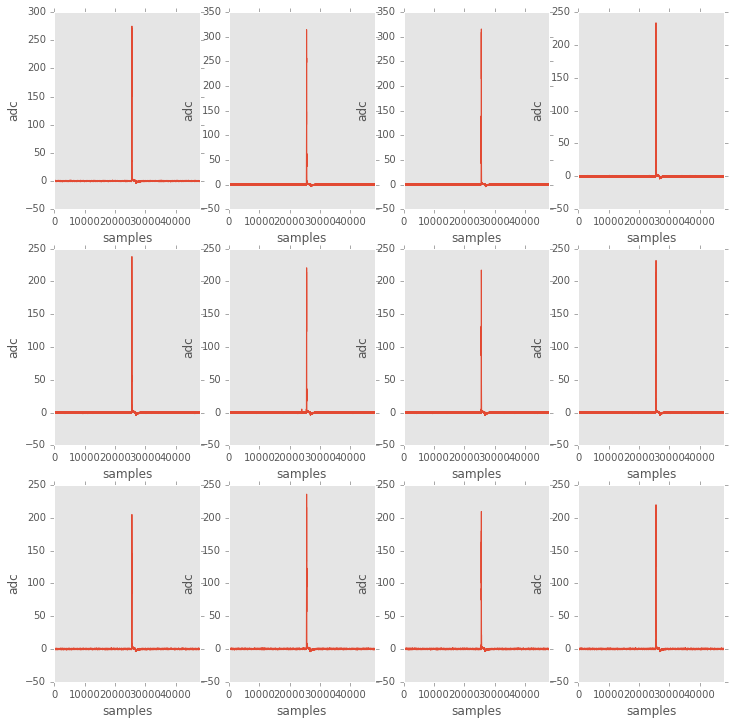

Press a key...


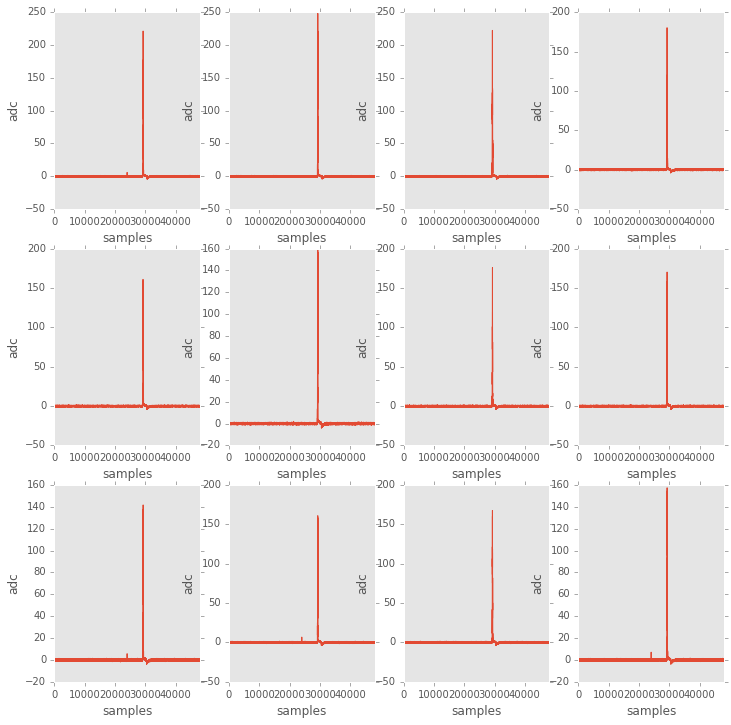

Press a key...


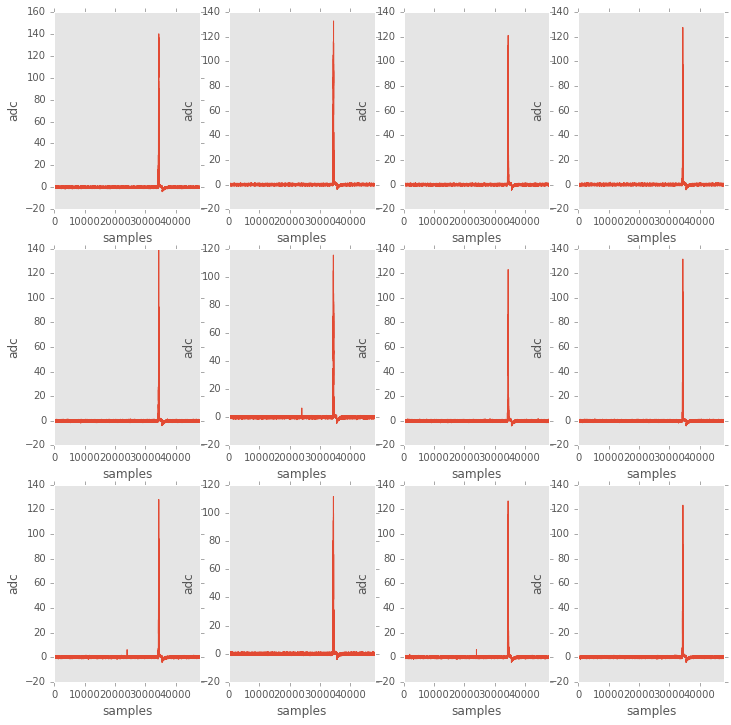

Press a key...


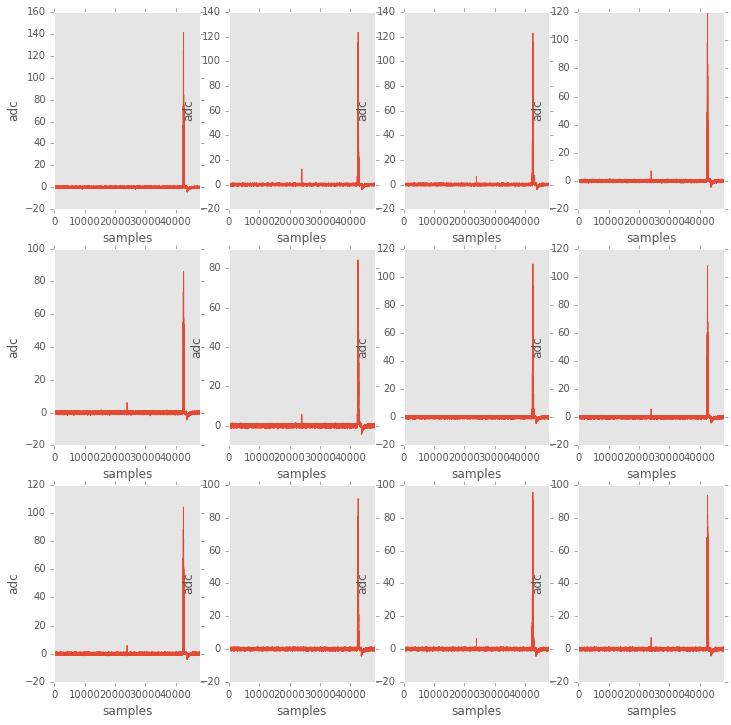

Press a key...


In [354]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(10))

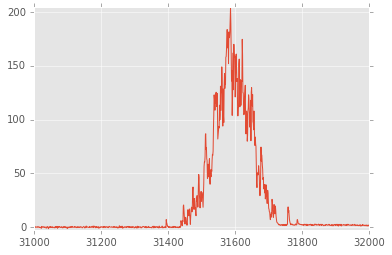

In [355]:
pmtcw = pmtcwf[0, 0]
plts(pmtcw, signal_start=31000, signal_end=32000, offset=1)

In [359]:
def ana_wf():
    h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+")
    pmtcwf = h5f.root.RD.pmtcwf
    plts(pmtcwf[0, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[0, 0], signal_start=5750, signal_end=7000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=3280, signal_end=5000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=9800, signal_end=11000, offset=1)
    plt.show()
    h5f.close()

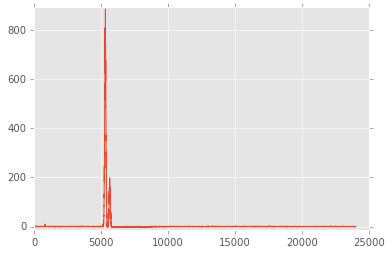

Press a key...


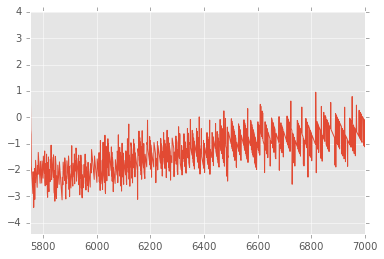

Press a key...


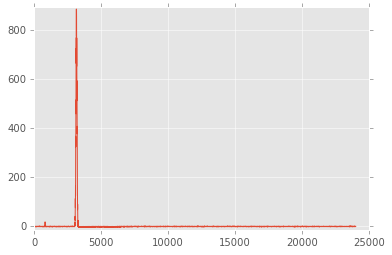

Press a key...


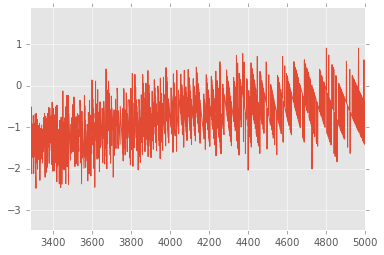

Press a key...


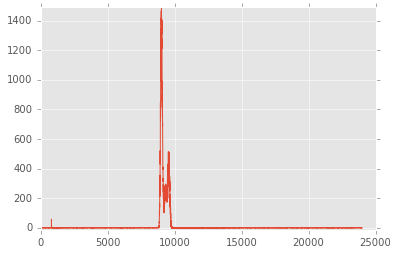

Press a key...


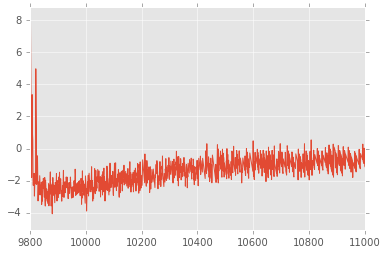

In [360]:
ana_wf()

In [361]:
h5f.close()